# Predicción: Series Temporales

## Master en Ciencia de Datos

### EXAMEN

### Alumno: Amadeo Gustavo Ancarani

# Planteo del Problema

Estamos ante la propuesta de estimar la demanda de energía en California. Los datos están disponibles en periodicidad horaria y diaria. Son datos desde el 1 de julio del 2015 hasta el 30 de noviembre de 2021.

Se deben analizar las dos series temporales y realizar la predicción de los **primeros 7 días de diciembre de 2021 en periodicidad horaria** y **la predicción diaria de los 15 primeros días de diciembre 2021**. El objetivo del informe consiste en elaborar un modelo predictivo. No existe ni preferencia ni obligación para la utilización de las diferentes técnicas aprendidas.

Tened en cuenta que el lector del informe desconoce las características de la Base de Datos y no tiene un modelo previo para comparar la calidad ni el “performance” del modelo. El informe debe estar bien estructurado, incluyendo los gráficos y tablas necesarias, pero no olvidando que es una publicación definitiva (No es una presentación ni un borrador). El informe deberá documentar las diferentes etapas del análisis, los resultados finales y las conclusiones.

La solución no es única. Se debe entregar un fichero (o varios) que incluya el código utilizado, dos ficheros csv con las prediciones (horarias y diarias) y un informe en formato pdf que no debe incluir código.

El día del examen se subirán los archivos al campus virtual.


# Pasos a seguir para la estimación Diaria

Se solicita predecir 15 dias del mes de diciembre.

Debemos realizar los siguientes pasos:
1. Importar los datos y librerías
2. Tranformarlos para el tratamiento
3. Graficar la serie temporal
4. Determinar los periodos a considerar para realizar la predicción.
5. Decidir los modelos para estimar
6. Realizar la predicción con el mejor modelo

# 1. Importación de datos y librerías

In [1]:
import pandas as pd
import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.forecasting.ets import AutoETS
# AutoArima Function
from sktime.forecasting.arima import AutoARIMA
from prophet import Prophet
from pandas.tseries.offsets import MonthEnd
%matplotlib inline
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from datetime import timedelta
import statsmodels.api as sm
sns.set()

Importing plotly failed. Interactive plots will not work.


In [2]:
data = pd.read_excel('DemandaEnergia.xlsx', sheet_name='Daily Data')#, encoding='latin-1', error_bad_lines=False)
data

Region Local date Time zone       D
0       CAL 2015-07-01   Pacific  978699
1       CAL 2015-07-02   Pacific  962751
2       CAL 2015-07-03   Pacific  887079
3       CAL 2015-07-04   Pacific  830874
4       CAL 2015-07-05   Pacific  791310
...     ...        ...       ...     ...
2340    CAL 2021-11-26   Pacific  625052
2341    CAL 2021-11-27   Pacific  622892
2342    CAL 2021-11-28   Pacific  622017
2343    CAL 2021-11-29   Pacific  698831
2344    CAL 2021-11-30   Pacific  709568

[2345 rows x 4 columns]

#### Primeros análisis:

Columna 'Region':

In [3]:
data['Region'].value_counts()

CAL    2345
Name: Region, dtype: int64

Podemos descartarla

In [4]:
data.drop(columns=['Region'], inplace=True)

Columna 'Time zone':

In [5]:
data['Time zone'].value_counts()

Pacific    2345
Name: Time zone, dtype: int64

Podemos descartarla

In [6]:
data.drop(columns=['Time zone'], inplace=True)

Columna 'Local Date':

In [7]:
data['Local date'].dtypes

dtype('<M8[ns]')

In [8]:
data['Local date'] = pd.to_datetime(data['Local date'])

data.rename(columns={'Local date': 'date'}, inplace=True)

data.set_index(['date'], inplace=True)

data

D
date              
2015-07-01  978699
2015-07-02  962751
2015-07-03  887079
2015-07-04  830874
2015-07-05  791310
...            ...
2021-11-26  625052
2021-11-27  622892
2021-11-28  622017
2021-11-29  698831
2021-11-30  709568

[2345 rows x 1 columns]

Chequeo posibles valores faltantes en 'date':

In [9]:
diario = data.copy()
diario["fecha"] = diario.index
diario['date_check'] = diario.fecha.diff()
diario.date_check.value_counts()

1 days    2344
Name: date_check, dtype: int64

In [10]:
diario[diario['D'].isna()]

Empty DataFrame
Columns: [D, fecha, date_check]
Index: []

No se verificaron errores en las fechas observadas ya que por cada observación tenemos un dia de diferencia.

Columna 'D':

In [11]:
data.rename(columns={'D': 'Demanda'}, inplace=True)

data.Demanda.dtype

dtype('int64')

In [12]:
data.max()

Demanda    1160559
dtype: int64

### Grafico la serie con distintas aperturas

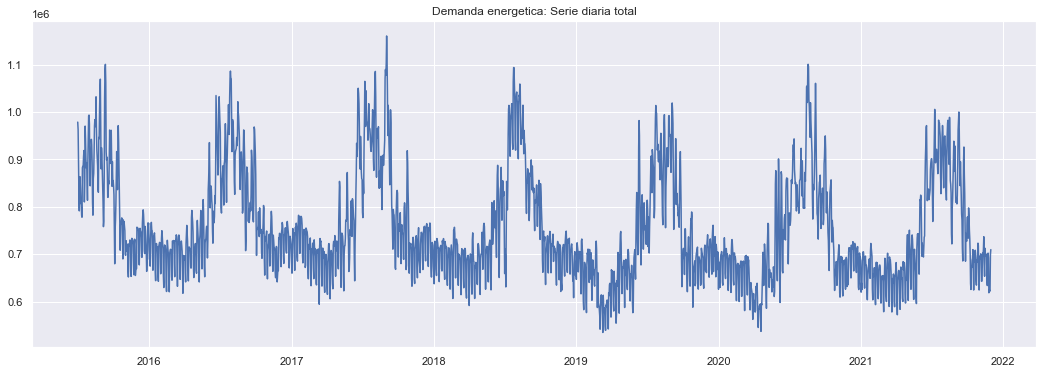

In [13]:
plt.figure(figsize=(18, 6))
plt.title('Demanda energetica: Serie diaria total')
plt.plot(data)
plt.savefig('images/diario/Demandadiariatotal.png')
plt.show();

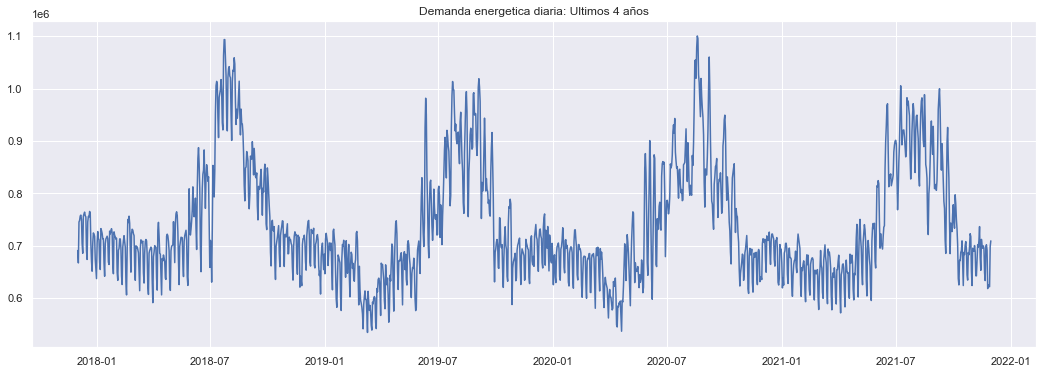

In [14]:
plt.figure(figsize=(18, 6))
plt.title('Demanda energetica diaria: Ultimos 4 años')
plt.plot(data.iloc[-365*4:])
plt.savefig('images/diario/Demandadiaria4anos.png')
plt.show();

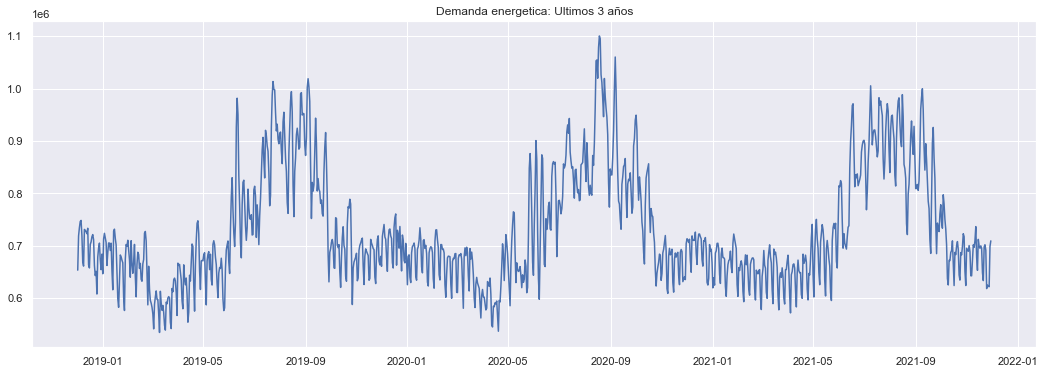

In [15]:
plt.figure(figsize=(18, 6))
plt.title('Demanda energetica: Ultimos 3 años')
plt.plot(data.iloc[-365*3:])
plt.savefig('images/diario/Demandadiaria3anos.png')
plt.show();

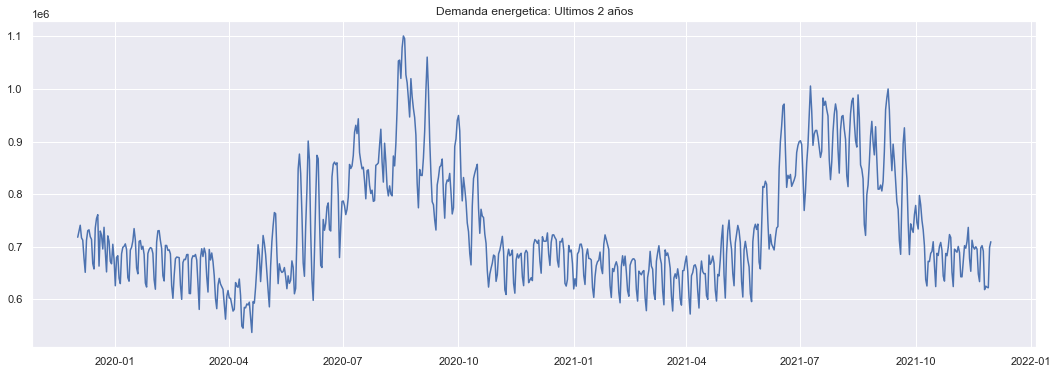

In [16]:
plt.figure(figsize=(18, 6))
plt.title('Demanda energetica: Ultimos 2 años')
plt.plot(data.iloc[-365*2:])
plt.savefig('images/diario/Demandadiaria2anos.png')
plt.show();

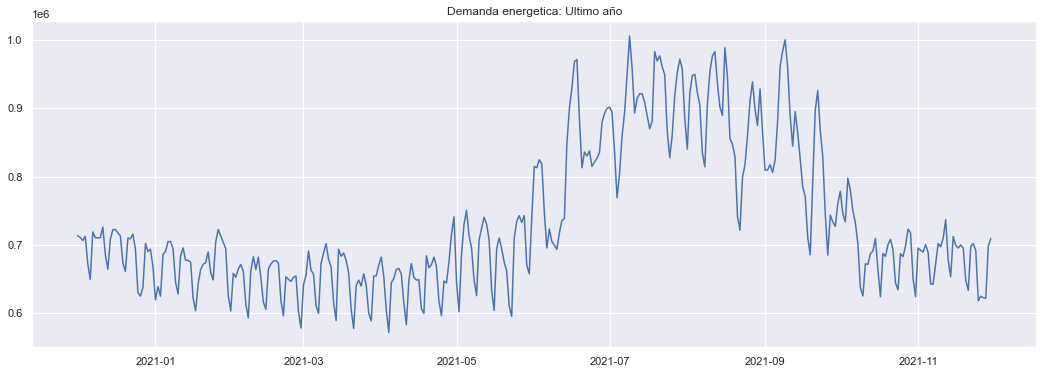

In [17]:
plt.figure(figsize=(18, 6))
plt.title('Demanda energetica: Ultimo año')
plt.plot(data.iloc[-365:])
plt.savefig('images/diario/Demandadiaria1anos.png')
plt.show();

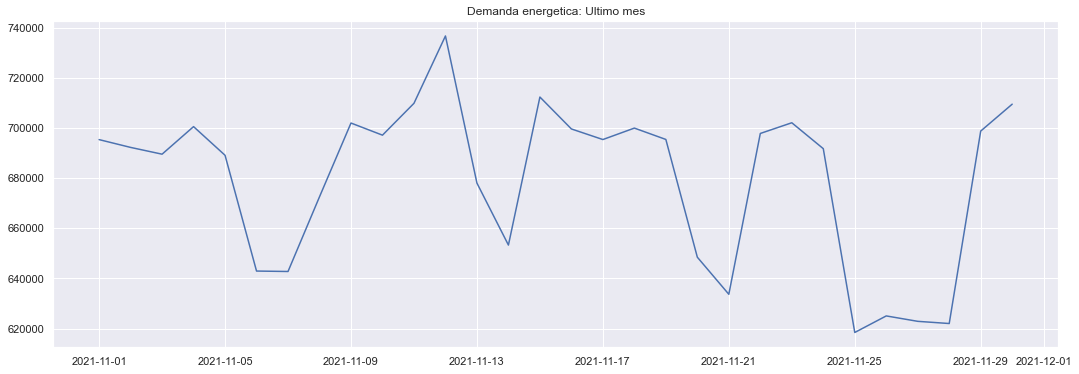

In [20]:
plt.figure(figsize=(18, 6))
plt.title('Demanda energetica: Ultimo mes')
plt.plot(data.iloc[-30:])
plt.savefig('images/diario/Demandadiariames.png')
plt.show();

### Descomposición de la serie

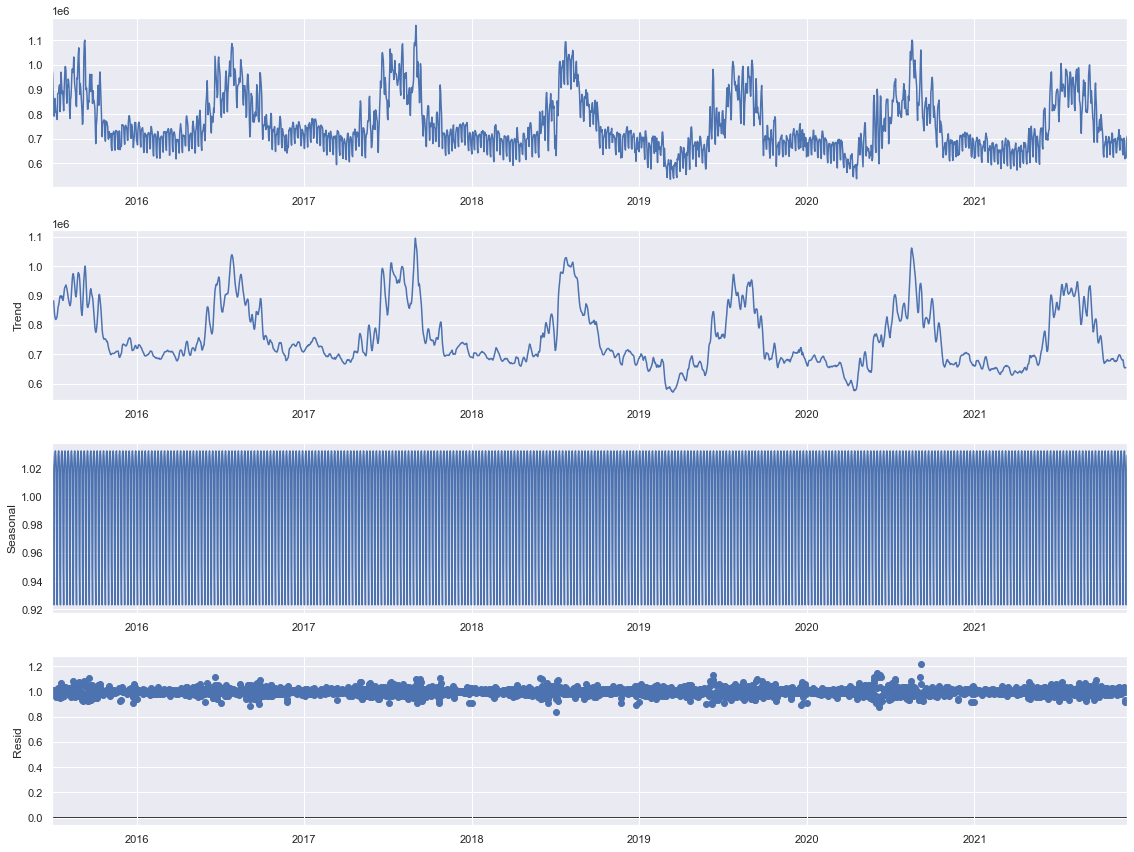

In [21]:
plt.rcParams["figure.figsize"] = (16,12)
result = seasonal_decompose(data, model='multiplicative')
result.plot()
plt.savefig('images/diario/descomptotal.png')
plt.show();

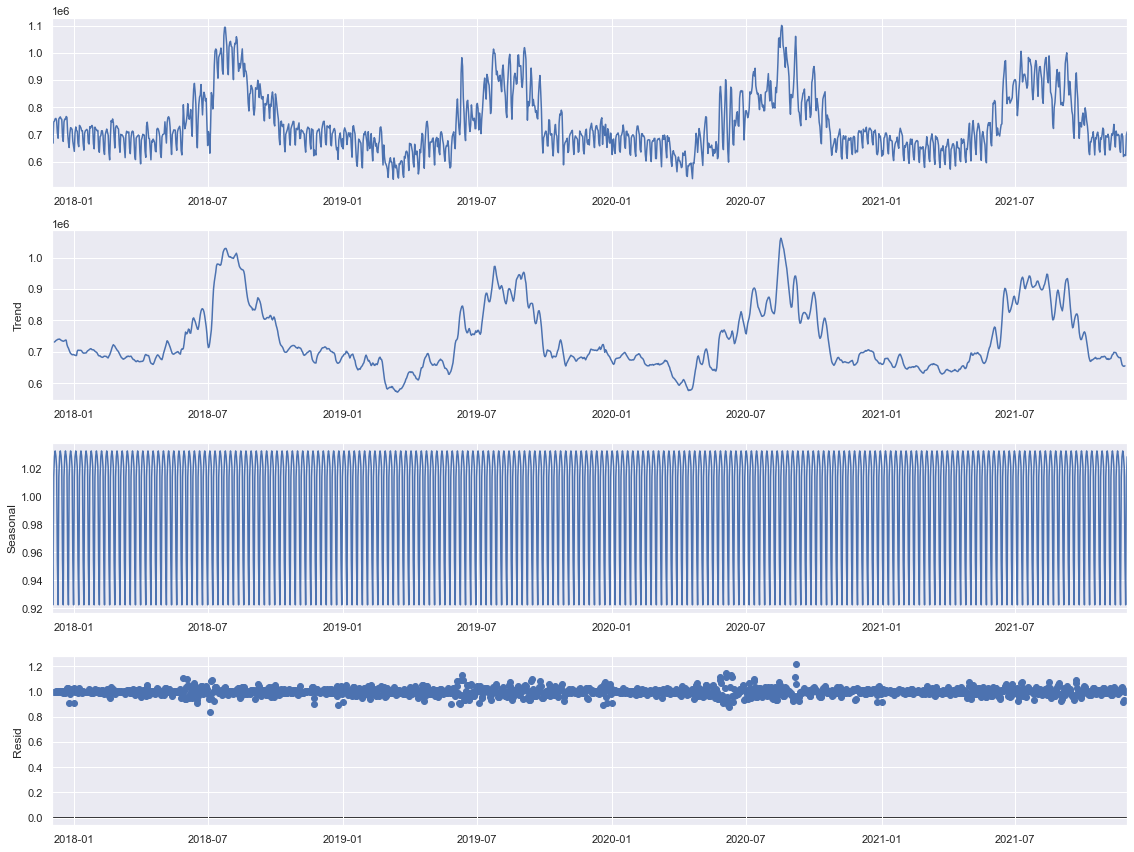

In [22]:
plt.rcParams["figure.figsize"] = (16,12)
result = seasonal_decompose(data.iloc[-365*4:], model='multiplicative')
result.plot()
plt.show();

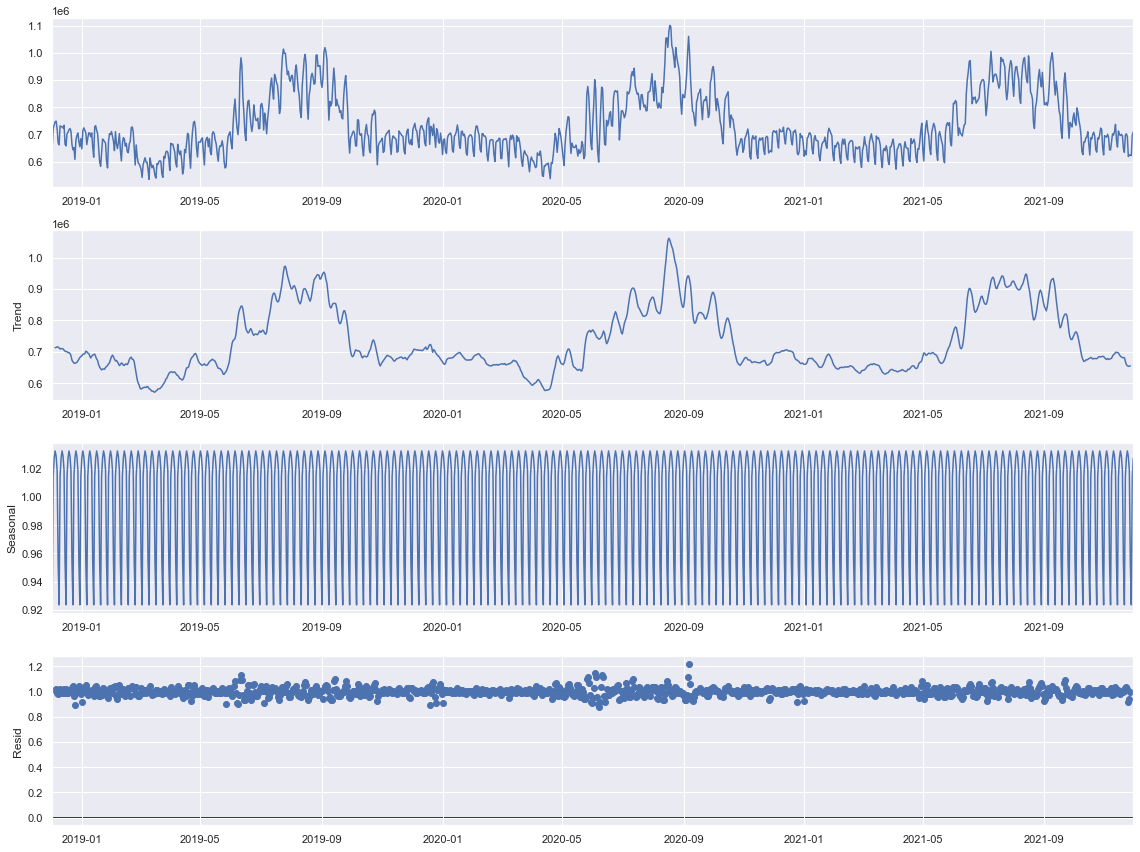

In [23]:
plt.rcParams["figure.figsize"] = (16,12)
result = seasonal_decompose(data.iloc[-365*3:], model='multiplicative')
result.plot()
plt.show();

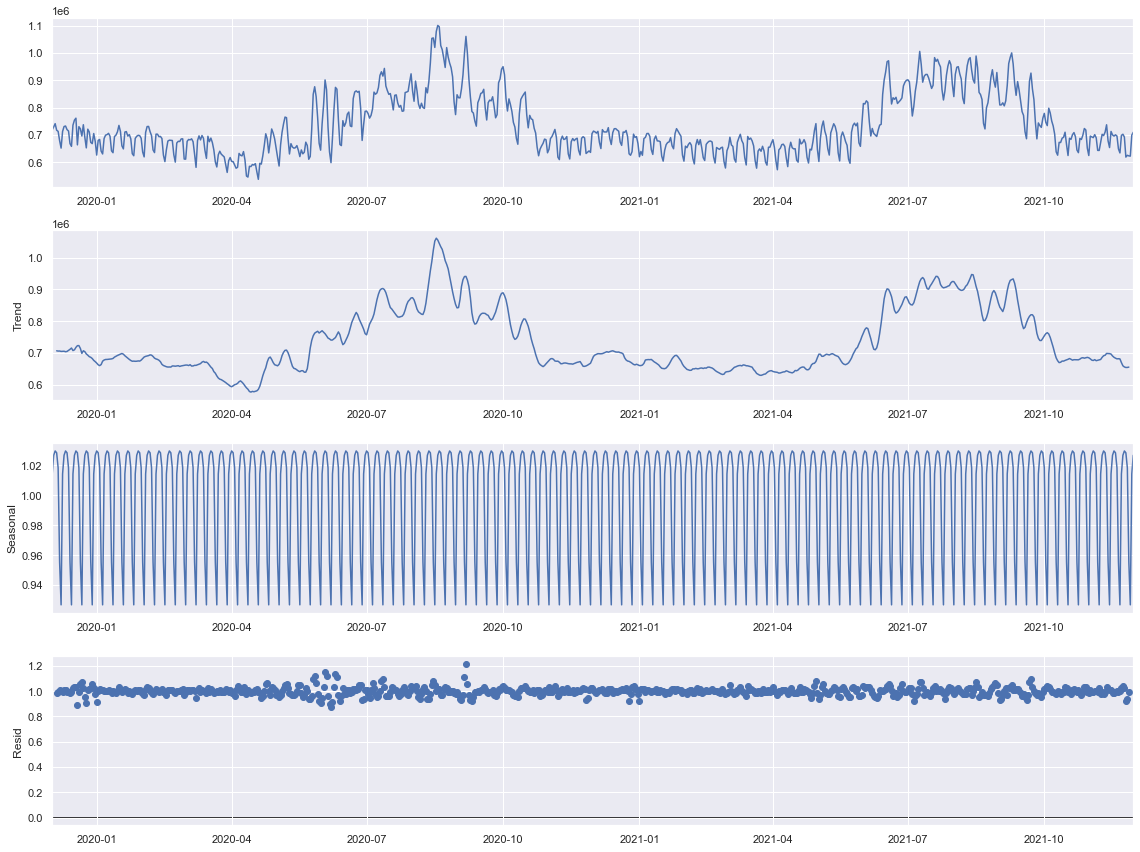

In [24]:
plt.rcParams["figure.figsize"] = (16,12)
result = seasonal_decompose(data.iloc[-365*2:], model='multiplicative')
result.plot()
plt.savefig('images/diario/descomp2anos.png')
plt.show();

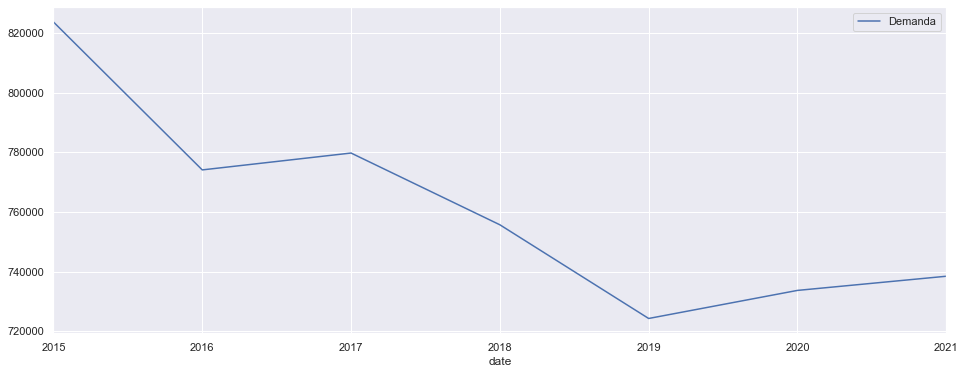

In [25]:
plt.rcParams["figure.figsize"] = (16,6)
data.resample('Y').mean().plot()
plt.savefig('images/diario/diaraianual.png')
plt.show();

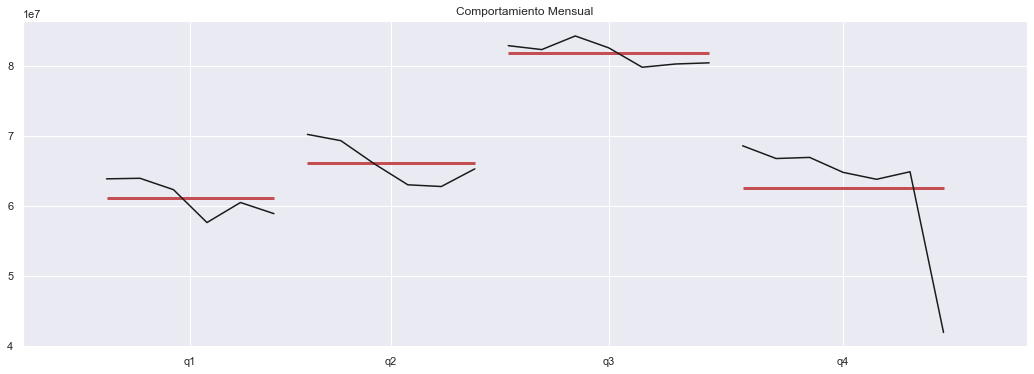

In [26]:
sns.set(rc={'figure.figsize':(18, 6)})
ax = plt.gca()
sm.graphics.tsa.quarter_plot(data.resample('Q').sum(), ax=ax)
ax.set_title('Comportamiento Mensual')
plt.savefig('images/diario/descomptrimestral.png')
plt.show();

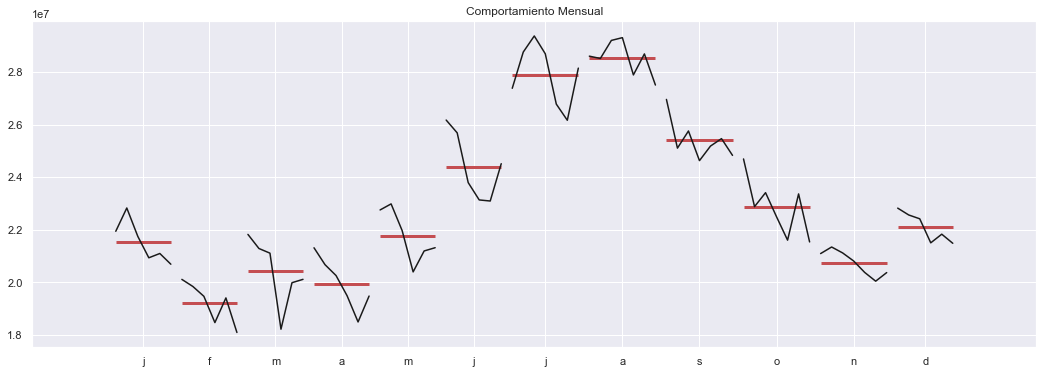

In [25]:
sns.set(rc={'figure.figsize':(18, 6)})
ax = plt.gca()
sm.graphics.tsa.month_plot(data.resample('M').sum(),ax=ax)
ax.set_title('Comportamiento Mensual')
plt.savefig('images/diario/descompmensual.png')
plt.show();

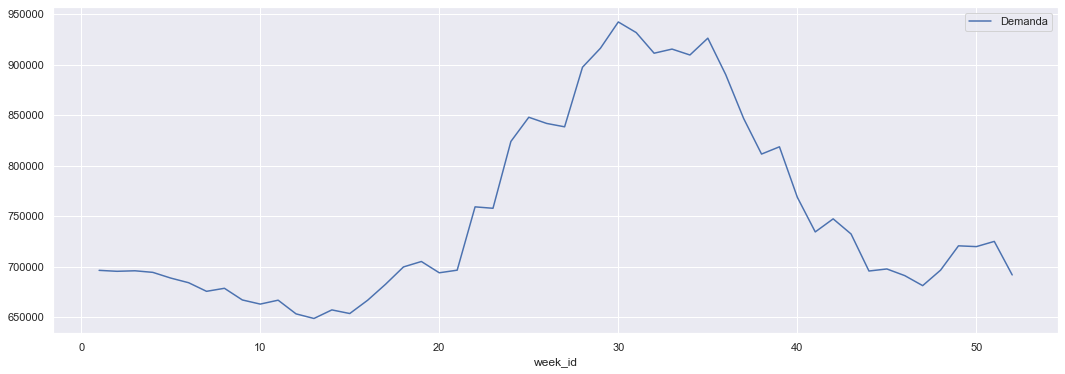

In [26]:
data2 = data.copy()
data2= data2.reset_index()
data2['week_id'] = data2['date'].dt.week
data2[['Demanda', 'week_id']].groupby('week_id').mean().iloc[0:52].plot()
plt.savefig('images/diario/descompsemanal.png')
plt.show();

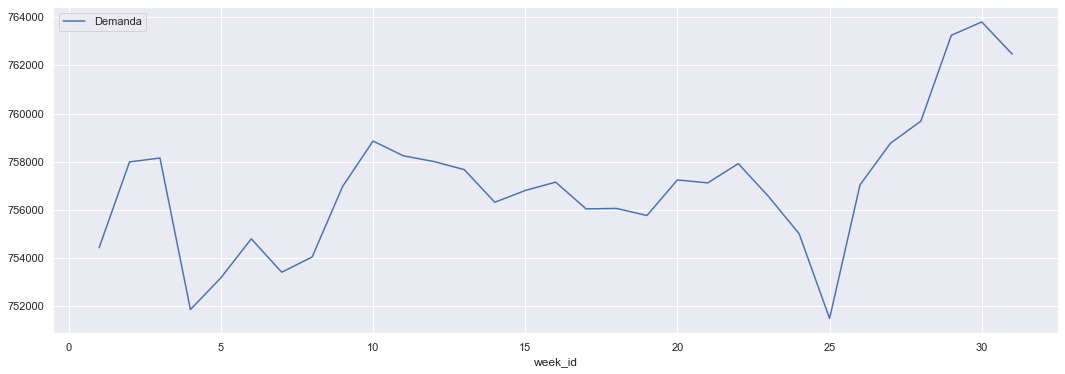

In [27]:
data2 = data.copy()
data2= data2.reset_index()
data2['week_id'] = data2['date'].dt.day
data2[['Demanda', 'week_id']].groupby('week_id').mean().plot()
plt.savefig('images/diario/diamesdiario.png')
plt.show();

# Determinación de los periodos a utilizar para la predicción

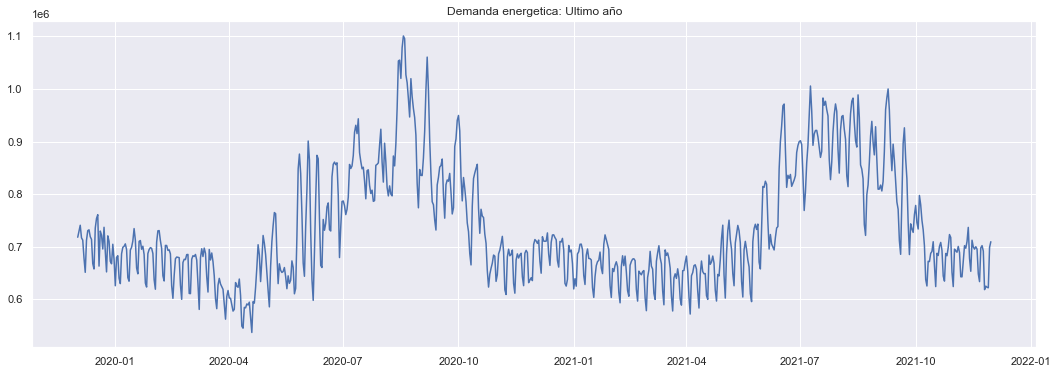

In [28]:
plt.figure(figsize=(18, 6))
plt.title('Demanda energetica: Ultimo año')
plt.plot(data.iloc[-365*2:])
plt.show();

In [29]:
len(data.iloc[-365*2:])

730

In [30]:
data.iloc[-365*2:]

Demanda
date               
2019-12-02   718087
2019-12-03   729011
2019-12-04   740865
2019-12-05   716966
2019-12-06   712592
...             ...
2021-11-26   625052
2021-11-27   622892
2021-11-28   622017
2021-11-29   698831
2021-11-30   709568

[730 rows x 1 columns]

<AxesSubplot:xlabel='date'>

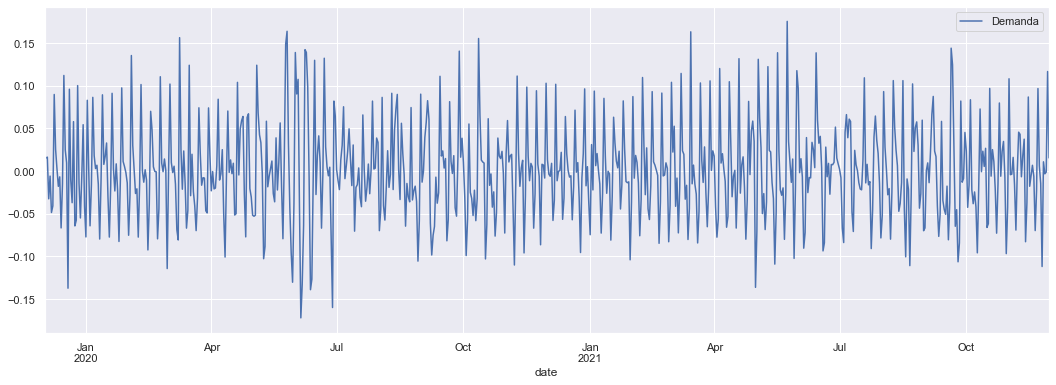

In [25]:
data_dif_log = np.log(data.iloc[-365*2:]).diff(1)

data_dif_log.plot()

<AxesSubplot:xlabel='date'>

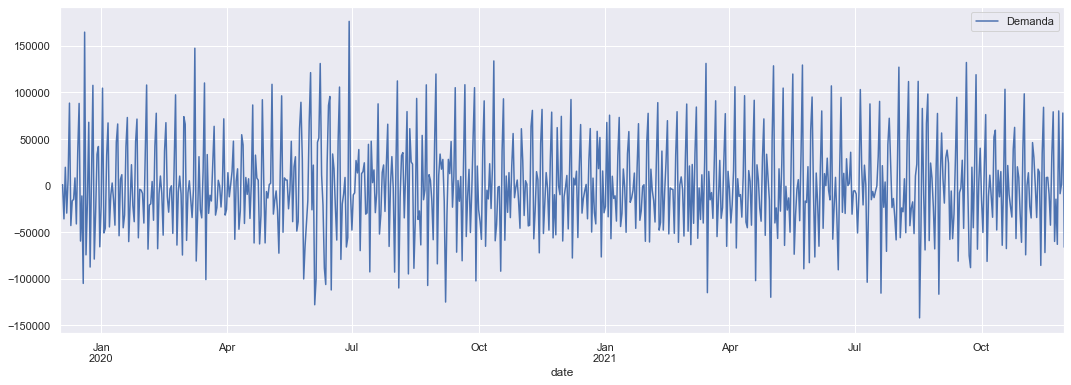

In [26]:
data_dif = (data.iloc[-365*2:]).diff(1).diff()

data_dif.plot()

In [27]:
np.mean(data_dif)

Demanda   -0.256868
dtype: float64

In [28]:
np.exp(np.mean(data_dif_log))

Demanda    0.999984
dtype: float64

## Selección período test

Se decide tomar a toda la informacion disponible salvo en los casos de los modelos ARIMA ya que son procesos más costosos computacionalmente.

In [29]:
test_dif = data_dif.iloc[-30:]
train_dif = data_dif.iloc[:(len(data_dif)-len(test_dif))]

In [30]:
test_dif_log = data_dif_log.iloc[-30:]
train_dif_log = data_dif_log.iloc[:(len(data_dif_log)-len(test_dif_log))]

In [31]:
test = data.iloc[-30:]
train = data.iloc[:(len(data)-len(test_dif))]

In [32]:
test_log = np.log(data.iloc[-30:])
train_log = np.log(data.iloc[:(len(data)-len(test_log))])

In [33]:
pd.concat([train, train_log, train_dif, train_dif_log], axis=1).tail()

Demanda    Demanda  Demanda   Demanda
date                                             
2021-10-27   698691  13.456964  20076.0  0.022859
2021-10-28   723206  13.491449   8725.0  0.034486
2021-10-29   717705  13.483814 -30016.0 -0.007635
2021-10-30   651362  13.386821 -60842.0 -0.096993
2021-10-31   624261  13.344324  39242.0 -0.042497

# Modelo 0: Media

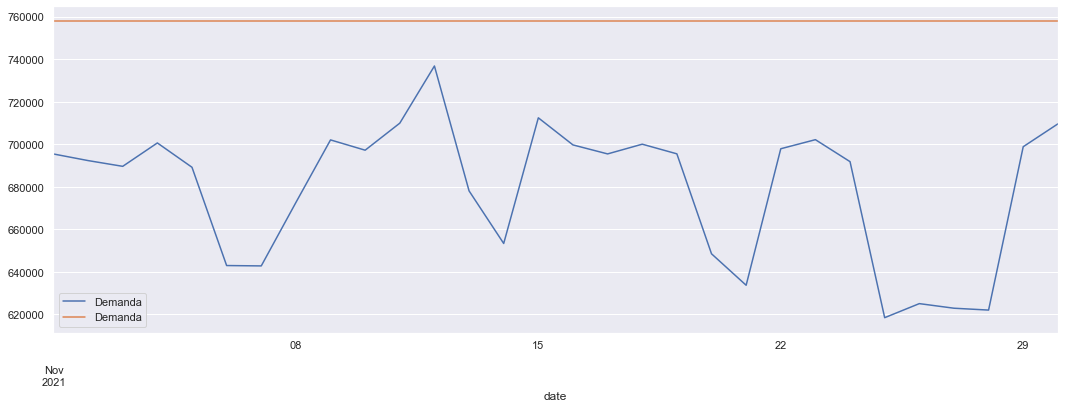

            Demanda        Demanda
date                              
2021-11-01   695421  757869.493737
2021-11-02   692311  757869.493737
2021-11-03   689608  757869.493737
2021-11-04   700606  757869.493737
2021-11-05   689165  757869.493737
2021-11-06   642959  757869.493737
2021-11-07   642785  757869.493737
2021-11-08   672601  757869.493737
2021-11-09   702036  757869.493737
2021-11-10   697199  757869.493737
2021-11-11   709913  757869.493737
2021-11-12   736790  757869.493737
2021-11-13   678070  757869.493737
2021-11-14   653333  757869.493737
2021-11-15   712420  757869.493737
2021-11-16   699677  757869.493737
2021-11-17   695450  757869.493737
2021-11-18   700021  757869.493737
2021-11-19   695487  757869.493737
2021-11-20   648487  757869.493737
2021-11-21   633689  757869.493737
2021-11-22   697877  757869.493737
2021-11-23   702148  757869.493737
2021-11-24   691807  757869.493737
2021-11-25   618445  757869.493737
2021-11-26   625052  757869.493737
2021-11-27   622892 

In [42]:
media = test.copy()
media['Demanda'] = np.mean(train).iloc[0]

pd.concat([test, media], axis=1).plot()
plt.show();
print(pd.concat([test, media], axis=1))
print('')
print('El hecho de intententar predecir a los valores futuros con la media historica genera un MAPE de: {}%'.format(round((mean_absolute_percentage_error(test, media))*100,2)))

# Modelo 1: AUTOETS

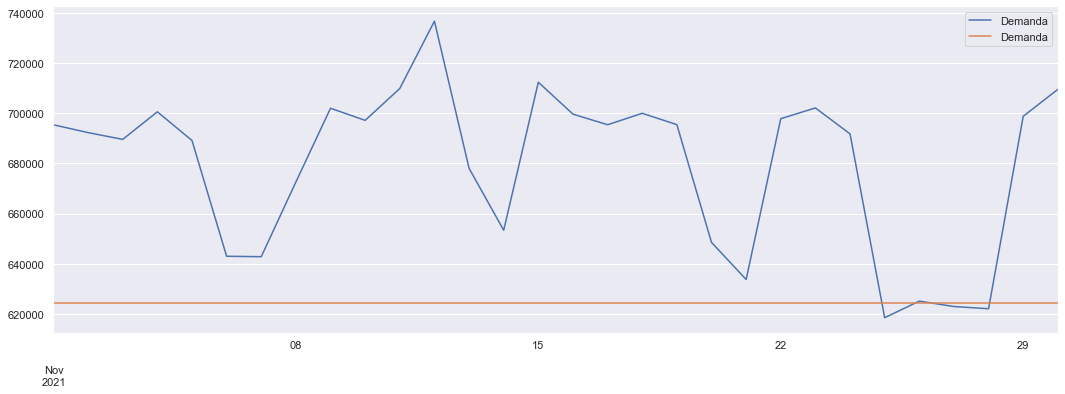

            Demanda  Demanda
2021-11-01   695421   624263
2021-11-02   692311   624263
2021-11-03   689608   624263
2021-11-04   700606   624263
2021-11-05   689165   624263
2021-11-06   642959   624263
2021-11-07   642785   624263
2021-11-08   672601   624263
2021-11-09   702036   624263
2021-11-10   697199   624263
2021-11-11   709913   624263
2021-11-12   736790   624263
2021-11-13   678070   624263
2021-11-14   653333   624263
2021-11-15   712420   624263
2021-11-16   699677   624263
2021-11-17   695450   624263
2021-11-18   700021   624263
2021-11-19   695487   624263
2021-11-20   648487   624263
2021-11-21   633689   624263
2021-11-22   697877   624263
2021-11-23   702148   624263
2021-11-24   691807   624263
2021-11-25   618445   624263
2021-11-26   625052   624263
2021-11-27   622892   624263
2021-11-28   622017   624263
2021-11-29   698831   624263
2021-11-30   709568   624263

El modelo ETS genera un MAPE de: 8.42%


In [40]:
ets_model = AutoETS(auto=True, sp=52, n_jobs=-1)
ets_model.fit(train.astype('float64').to_period('D'))
fh = np.arange(1, 31)
#fh
ets_pred = ets_model.predict(fh)
ets_pred = ets_pred.astype('int')
ets_pred.index = ets_pred.index.to_timestamp()
pd.concat([test, ets_pred], axis=1).plot()
plt.show();
print(pd.concat([test, ets_pred], axis=1))
print('')
print('El modelo ETS genera un MAPE de: {}%'.format(round((mean_absolute_percentage_error(test, ets_pred))*100,2)))

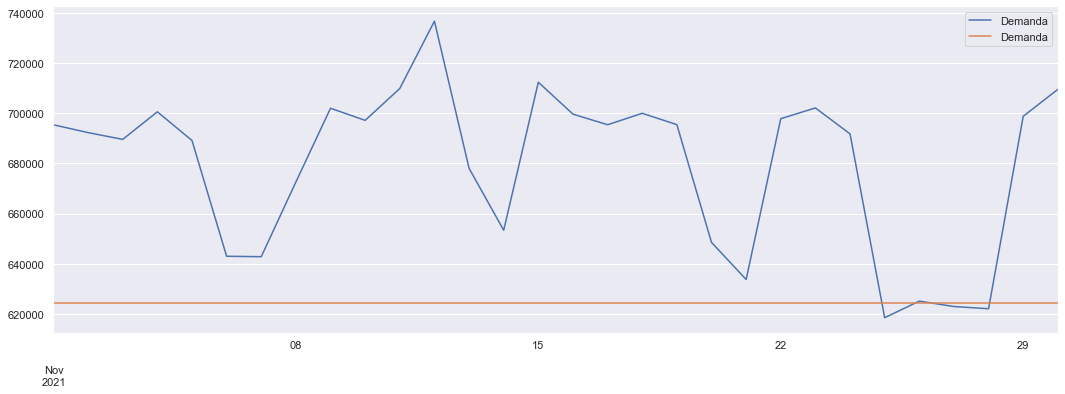

             Demanda  Demanda
2021-11-01  695421.0   624263
2021-11-02  692311.0   624263
2021-11-03  689608.0   624263
2021-11-04  700606.0   624263
2021-11-05  689165.0   624263
2021-11-06  642959.0   624263
2021-11-07  642785.0   624263
2021-11-08  672601.0   624263
2021-11-09  702036.0   624263
2021-11-10  697199.0   624263
2021-11-11  709913.0   624263
2021-11-12  736790.0   624263
2021-11-13  678070.0   624263
2021-11-14  653333.0   624263
2021-11-15  712420.0   624263
2021-11-16  699677.0   624263
2021-11-17  695450.0   624263
2021-11-18  700021.0   624263
2021-11-19  695487.0   624263
2021-11-20  648487.0   624263
2021-11-21  633689.0   624263
2021-11-22  697877.0   624263
2021-11-23  702148.0   624263
2021-11-24  691807.0   624263
2021-11-25  618445.0   624263
2021-11-26  625052.0   624263
2021-11-27  622892.0   624263
2021-11-28  622017.0   624263
2021-11-29  698831.0   624263
2021-11-30  709568.0   624263

El modelo ETS en logaritmos genera un MAPE de: 8.42%


In [41]:
ets_model_log = AutoETS(auto=True, sp=52, n_jobs=-1)
ets_model_log.fit(train_log.astype('float64').to_period('D'))
fh = np.arange(1, 31)
#fh
ets_pred_log = ets_model_log.predict(fh)
ets_pred_log = np.exp(ets_pred_log).astype('int')
ets_pred_log.index = ets_pred_log.index.to_timestamp()
pd.concat([np.exp(test_log), ets_pred_log], axis=1).plot()
plt.show();
print(pd.concat([np.exp(test_log), ets_pred_log], axis=1))
print('')

print('El modelo ETS en logaritmos genera un MAPE de: {}%'.format(round((mean_absolute_percentage_error(np.exp(test_log), ets_pred_log))*100,2)))

# Modelo 2: AUTOARIMA

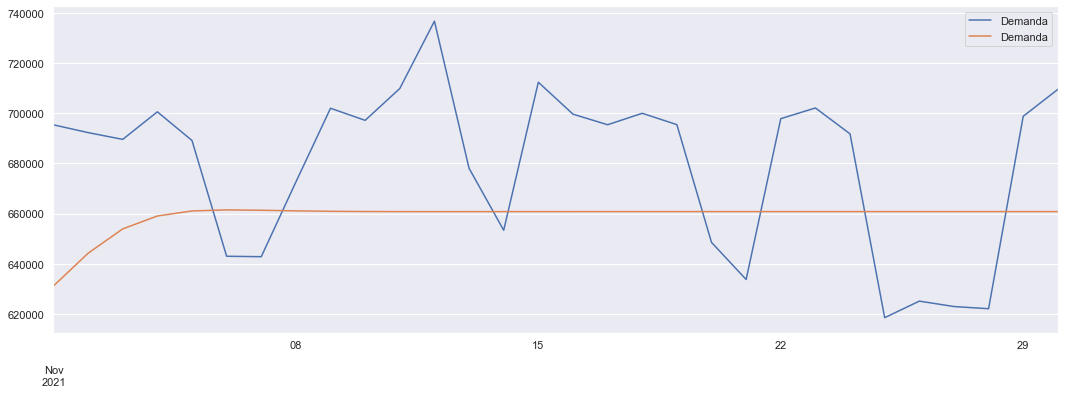

            Demanda        Demanda
2021-11-01   695421  631099.121688
2021-11-02   692311  644162.257760
2021-11-03   689608  653878.086076
2021-11-04   700606  659030.172916
2021-11-05   689165  661037.111830
2021-11-06   642959  661463.358272
2021-11-07   642785  661316.575272
2021-11-08   672601  661076.597987
2021-11-09   702036  660903.615182
2021-11-10   697199  660813.809876
2021-11-11   709913  660779.770404
2021-11-12   736790  660773.170450
2021-11-13   678070  660776.213953
2021-11-14   653333  660780.607875
2021-11-15   712420  660783.682597
2021-11-16   699677  660785.245479
2021-11-17   695450  660785.821148
2021-11-18   700021  660785.921297
2021-11-19   695487  660785.859734
2021-11-20   648487  660785.779528
2021-11-21   633689  660785.724965
2021-11-22   697877  660785.697810
2021-11-23   702148  660785.688105
2021-11-24   691807  660785.686626
2021-11-25   618445  660785.687848
2021-11-26   625052  660785.689308
2021-11-27   622892  660785.690275
2021-11-28   622017 

In [42]:
#  Auto ARIMA Model
forecaster = AutoARIMA(sp=52,suppress_warnings=True)
#  Auto ARIMA Model Estimation
forecaster.fit(train.iloc[-365:].to_period('D'))
#  Auto ARIMA Forecast (log)
arima_pred = forecaster.predict(fh)
#  Auto ARIMA Forecast (original)
arima_pred.index = arima_pred.index.to_timestamp()
pd.concat([test, arima_pred], axis=1).plot()
plt.show();
print(pd.concat([test, arima_pred], axis=1))
print('')
print('El modelo ARIMA genera un MAPE de: {}%'.format(round((mean_absolute_percentage_error(test, arima_pred))*100,2)))

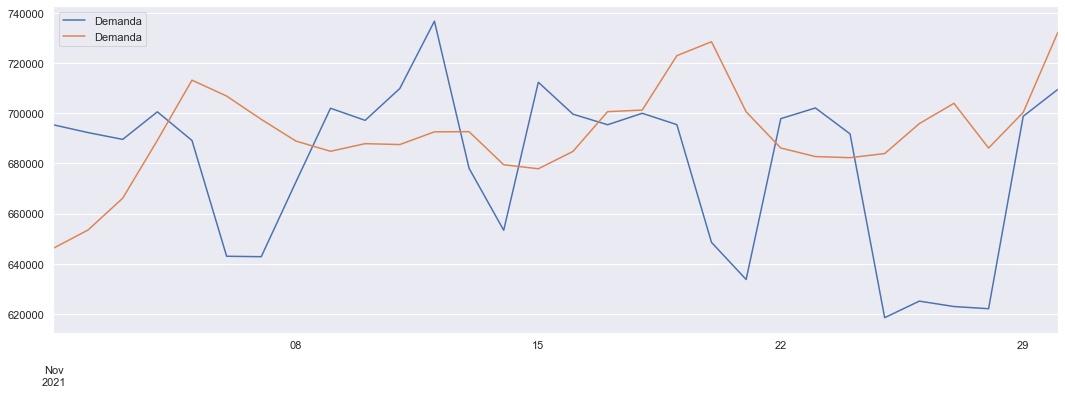

            Demanda        Demanda
2021-11-01   695421  646174.260421
2021-11-02   692311  653451.593507
2021-11-03   689608  666136.597313
2021-11-04   700606  689222.007841
2021-11-05   689165  713240.536933
2021-11-06   642959  706900.038749
2021-11-07   642785  697603.379367
2021-11-08   672601  688938.353703
2021-11-09   702036  684862.345567
2021-11-10   697199  687895.217465
2021-11-11   709913  687538.900327
2021-11-12   736790  692614.697715
2021-11-13   678070  692684.613893
2021-11-14   653333  679484.220235
2021-11-15   712420  677878.798837
2021-11-16   699677  684803.393020
2021-11-17   695450  700670.156791
2021-11-18   700021  701302.577010
2021-11-19   695487  723018.478561
2021-11-20   648487  728582.652398
2021-11-21   633689  700608.915432
2021-11-22   697877  686162.623043
2021-11-23   702148  682748.101789
2021-11-24   691807  682307.284632
2021-11-25   618445  683935.058416
2021-11-26   625052  695900.215776
2021-11-27   622892  703995.508197
2021-11-28   622017 

In [43]:
#  Auto ARIMA Model
forecaster_log = AutoARIMA(sp=52,suppress_warnings=True)
#  Auto ARIMA Model Estimation
forecaster_log.fit(train_log.iloc[-365:].to_period('D'))
#  Auto ARIMA Forecast (log)
arima_pred_log = forecaster_log.predict(fh)
#  Auto ARIMA Forecast (original)
arima_pred_log.index = arima_pred_log.index.to_timestamp()
arima_pred_log = np.exp(arima_pred_log)

pd.concat([test, arima_pred_log], axis=1).plot()
plt.show();
print(pd.concat([test, arima_pred_log], axis=1))
print('')
print('El modelo ARIMA en logaritmos genera un MAPE de: {}%'.format(round((mean_absolute_percentage_error(test, arima_pred_log))*100,2)))

# Modelo 3: Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


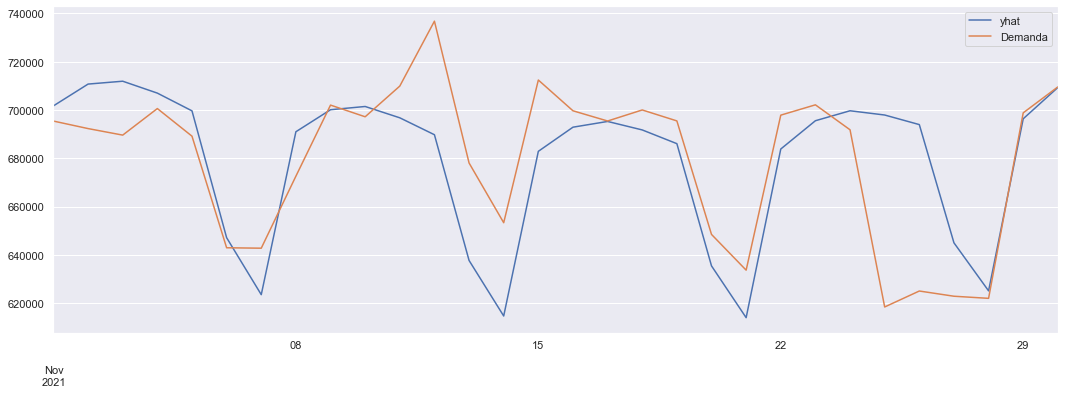


              yhat  Demanda
2021-11-01  701719   695421
2021-11-02  710741   692311
2021-11-03  711926   689608
2021-11-04  706997   700606
2021-11-05  699651   689165
2021-11-06  647134   642959
2021-11-07  623544   642785
2021-11-08  691000   672601
2021-11-09  700120   702036
2021-11-10  701462   697199
2021-11-11  696773   709913
2021-11-12  689767   736790
2021-11-13  637707   678070
2021-11-14  614705   653333
2021-11-15  682892   712420
2021-11-16  692890   699677
2021-11-17  695263   695450
2021-11-18  691752   700021
2021-11-19  686065   695487
2021-11-20  635454   648487
2021-11-21  614013   633689
2021-11-22  683850   697877
2021-11-23  695563   702148
2021-11-24  699686   691807
2021-11-25  697929   618445
2021-11-26  693964   625052
2021-11-27  645008   622892
2021-11-28  625119   622017
2021-11-29  696369   698831
2021-11-30  709325   709568

El modelo Prophet genera un MAPE de: 2.7%


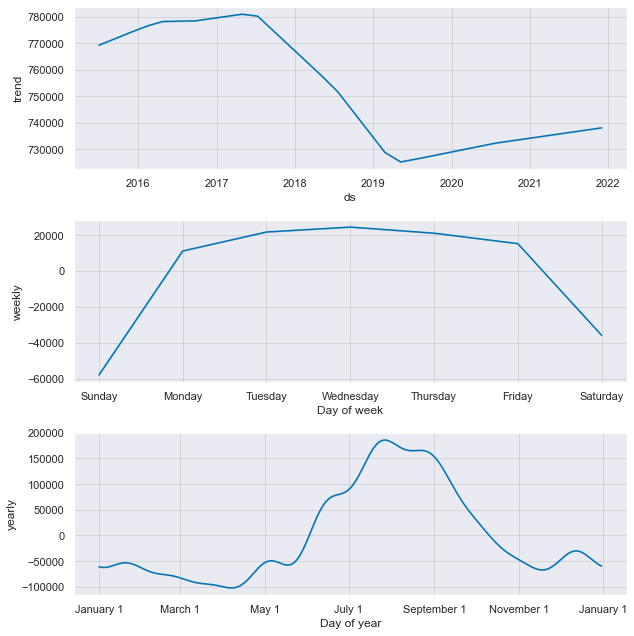

In [44]:
prophet_train = train.reset_index()
prophet_train.columns = ['ds', 'y']


m = Prophet()
m.fit(prophet_train)
future = m.make_future_dataframe(periods=30, freq='D')
forecast = m.predict(future)
prophet_pred = forecast[['ds','yhat']].copy()
prophet_pred.set_index(['ds'], inplace=True)
pd.concat([prophet_pred.iloc[-30:].astype('int'), test], axis=1).plot()
plt.savefig('images/diario/predtest.png')
plt.show();
print('')
print(pd.concat([prophet_pred.iloc[-30:].astype('int'), test], axis=1))
print('')

print('El modelo Prophet genera un MAPE de: {}%'.format(round((mean_absolute_percentage_error(test, prophet_pred.iloc[-30:].astype('int')))*100,2)))

fig2 = m.plot_components(forecast)
plt.savefig('images/diario/testcomponents.png')
plt.show();

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


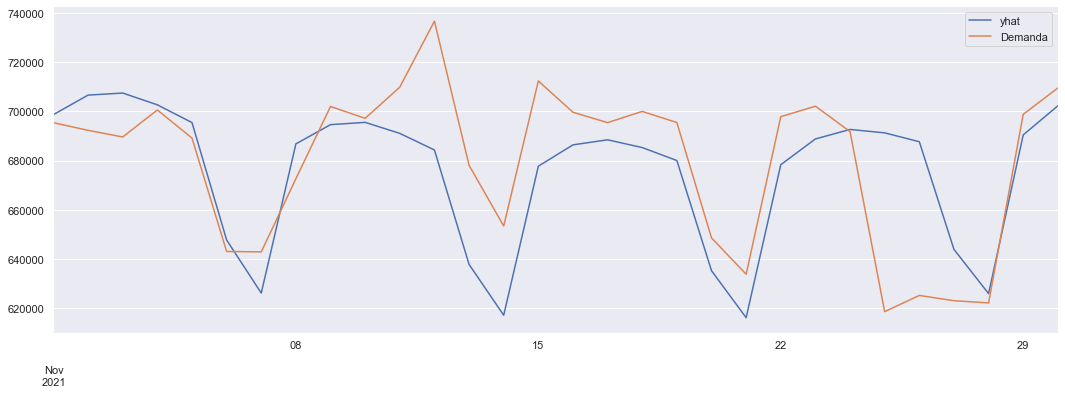


              yhat  Demanda
2021-11-01  698720   695421
2021-11-02  706669   692311
2021-11-03  707503   689608
2021-11-04  702705   700606
2021-11-05  695478   689165
2021-11-06  647638   642959
2021-11-07  626016   642785
2021-11-08  686799   672601
2021-11-09  694630   702036
2021-11-10  695560   697199
2021-11-11  691066   709913
2021-11-12  684308   736790
2021-11-13  637695   678070
2021-11-14  616989   653333
2021-11-15  677696   712420
2021-11-16  686397   699677
2021-11-17  688455   695450
2021-11-18  685293   700021
2021-11-19  680007   695487
2021-11-20  635125   648487
2021-11-21  615988   633689
2021-11-22  678308   697877
2021-11-23  688802   702148
2021-11-24  692677   691807
2021-11-25  691283   618445
2021-11-26  687674   625052
2021-11-27  643814   622892
2021-11-28  625785   622017
2021-11-29  690448   698831
2021-11-30  702308   709568

El modelo Prophet con logaritmos genera un MAPE de: 2.8%


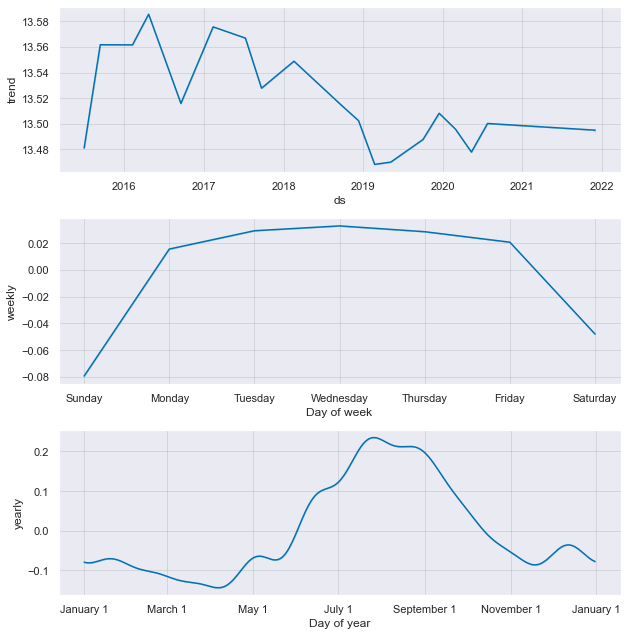

In [45]:
prophet_train_log = train_log.reset_index()
prophet_train_log.columns = ['ds', 'y']

m_log = Prophet()
m_log.fit(prophet_train_log)
future_log = m_log.make_future_dataframe(periods=30, freq='D')
forecast_log = m_log.predict(future_log)
prophet_pred_log = forecast_log[['ds','yhat']].copy()
prophet_pred_log.set_index(['ds'], inplace=True)
prophet_pred_log = np.exp(prophet_pred_log)
pd.concat([prophet_pred_log.iloc[-30:].astype('int'), test], axis=1).plot()
plt.show();
print('')
print(pd.concat([prophet_pred_log.iloc[-30:].astype('int'), test], axis=1))
print('')

print('El modelo Prophet con logaritmos genera un MAPE de: {}%'.format(round((mean_absolute_percentage_error(test, prophet_pred_log.iloc[-30:].astype('int')))*100,2)))

fig2 = m_log.plot_components(forecast_log)
plt.show();

# Estimación final para los meses de noviembre y diciembre mediante un modelo Prophet con aplicación de logaritmos

Para comenzar, concatenamos los dataframes de los distintos intervalos de la serie: el primero y el tercero son los datos reales recogidos durante esas fechas, mientras que el segundo es la predicción realizada con el modelo ETS para paliar la bajada de las matriculaciones como consecuencia de la pandemia.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


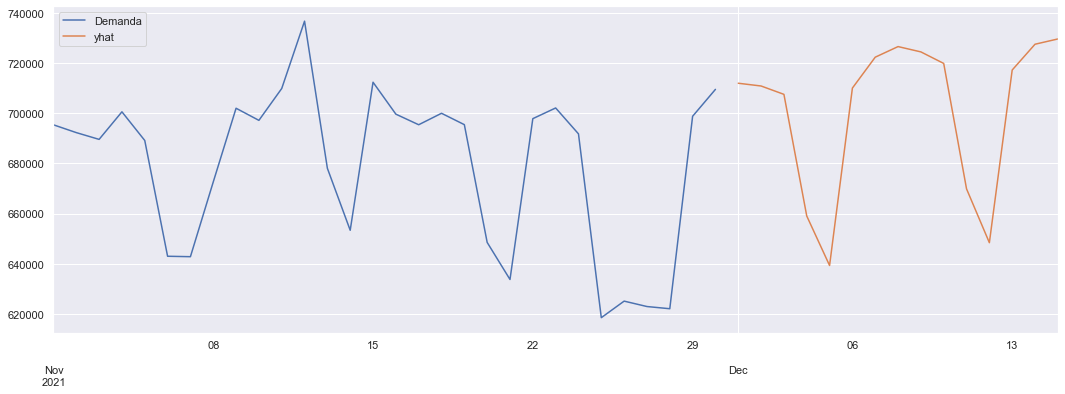


            Demanda
2021-11-16   699677
2021-11-17   695450
2021-11-18   700021
2021-11-19   695487
2021-11-20   648487
2021-11-21   633689
2021-11-22   697877
2021-11-23   702148
2021-11-24   691807
2021-11-25   618445
2021-11-26   625052
2021-11-27   622892
2021-11-28   622017
2021-11-29   698831
2021-11-30   709568
2021-12-01   712016
2021-12-02   710912
2021-12-03   707581
2021-12-04   659031
2021-12-05   639275
2021-12-06   710086
2021-12-07   722414
2021-12-08   726645
2021-12-09   724524
2021-12-10   719916
2021-12-11   669852
2021-12-12   648374
2021-12-13   717289
2021-12-14   727584
2021-12-15   729687


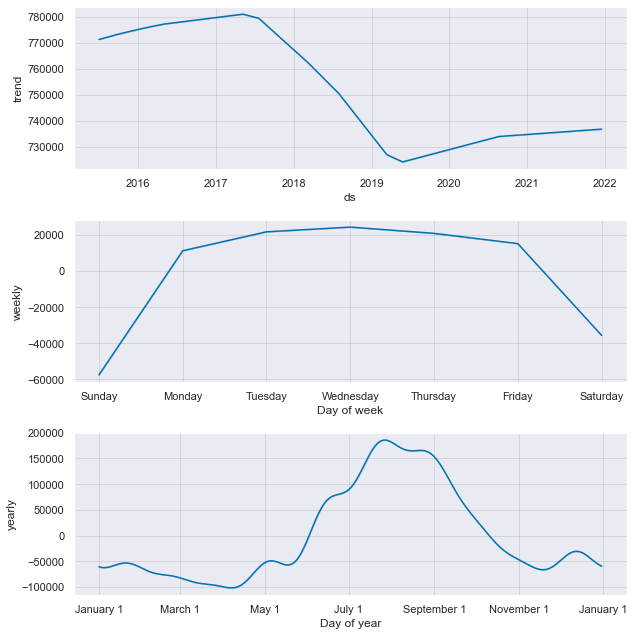

In [46]:
prophet_data = data.reset_index()
prophet_data.columns = ['ds', 'y']

m = Prophet()
m.fit(prophet_data)
future = m.make_future_dataframe(periods=15, freq='D')
forecast = m.predict(future)
prophet_pred = forecast[['ds','yhat']].copy()
prophet_pred.set_index(['ds'], inplace=True)
pd.concat([test, prophet_pred.iloc[-15:].astype('int')]).plot()
plt.savefig('images/diario/preddiaria.png')
plt.show();
print('')
pred = prophet_pred.rename_axis(index=None).rename(columns={'yhat': 'Demanda'}).iloc[-15:].astype('int')
data2 = data.append(pred)
print(data2.tail(30))

fig2 = m.plot_components(forecast)
plt.show();

In [47]:
pred.reset_index().to_csv('dialyprediction.csv')

In [48]:
pred

Demanda
2021-12-01   712016
2021-12-02   710912
2021-12-03   707581
2021-12-04   659031
2021-12-05   639275
2021-12-06   710086
2021-12-07   722414
2021-12-08   726645
2021-12-09   724524
2021-12-10   719916
2021-12-11   669852
2021-12-12   648374
2021-12-13   717289
2021-12-14   727584
2021-12-15   729687

# Pasos a seguir para la estimación Horaria

Se solicita predecir 7 dias del mes de diciembre.

Debemos realizar los siguientes pasos:
1. Importar los datos y librerías
2. Tranformarlos para el tratamiento
3. Graficar la serie temporal
4. Determinar los periodos a considerar para realizar la predicción.
5. Decidir los modelos para estimar
6. Realizar la predicción con el mejor modelo

In [43]:
data = pd.read_excel('DemandaEnergia.xlsx', sheet_name='Hourly Data')#, encoding='latin-1', error_bad_lines=False)
data

Region            UTC time Local date  Local hour          Local time  \
0        CAL 2015-07-01 08:00:00 2015-07-01           1 2015-07-01 01:00:00   
1        CAL 2015-07-01 09:00:00 2015-07-01           2 2015-07-01 02:00:00   
2        CAL 2015-07-01 10:00:00 2015-07-01           3 2015-07-01 03:00:00   
3        CAL 2015-07-01 11:00:00 2015-07-01           4 2015-07-01 04:00:00   
4        CAL 2015-07-01 12:00:00 2015-07-01           5 2015-07-01 05:00:00   
...      ...                 ...        ...         ...                 ...   
56267    CAL 2021-11-30 19:00:00 2021-11-30          11 2021-11-30 11:00:00   
56268    CAL 2021-11-30 20:00:00 2021-11-30          12 2021-11-30 12:00:00   
56269    CAL 2021-11-30 21:00:00 2021-11-30          13 2021-11-30 13:00:00   
56270    CAL 2021-11-30 22:00:00 2021-11-30          14 2021-11-30 14:00:00   
56271    CAL 2021-11-30 23:00:00 2021-11-30          15 2021-11-30 15:00:00   

      Time zone      D  
0       Pacific  38210  
1       Pacific  35171  
2       Pacific  33243  
3       Pacific  31955  
4       Pacific  31199  
...         ...    ...  
56267   Pacific  29068  
56268   Pacific  28769  
56269   Pacific  29180  
56270   Pacific  29719  
56271   Pacific  30512  

[56272 rows x 7 columns]

#### Primeros análisis:

Columna 'Region':

In [44]:
data['Region'].value_counts()

CAL    56272
Name: Region, dtype: int64

Podemos descartarla

In [45]:
data.drop(columns=['Region'], inplace=True)

Columna 'Time Zone':

In [46]:
data['Time zone'].value_counts()

Pacific    56272
Name: Time zone, dtype: int64

Podemos descartarla

In [47]:
data.drop(columns=['Time zone'], inplace=True)

Verificamos posibles errores de carga en los datos diarios

In [48]:
diario = data.copy()
diario["fecha"] = diario['Local time']
diario['date_check'] = diario.fecha.diff()
diario.date_check.value_counts()

0 days 01:00:00    56258
0 days 00:00:00        7
0 days 02:00:00        6
Name: date_check, dtype: int64

Pruebo el mismo test para UTC time:

In [49]:
diario = data.copy()
diario["fecha"] = diario['UTC time']
diario['date_check'] = diario.fecha.diff()
diario.date_check.value_counts()

0 days 01:00:00    56271
Name: date_check, dtype: int64

Como UTC time está correcto, lo tomaré como index una vez esté ajustado al horario local.

Paso a modificar el UTC time

In [50]:
diario['UTC time'].dtype

dtype('<M8[ns]')

In [51]:
data['UTC time'] = pd.to_datetime(data['UTC time'])
data['UTC time'] = data['UTC time'] - timedelta(hours=7)
data

UTC time Local date  Local hour          Local time      D
0     2015-07-01 01:00:00 2015-07-01           1 2015-07-01 01:00:00  38210
1     2015-07-01 02:00:00 2015-07-01           2 2015-07-01 02:00:00  35171
2     2015-07-01 03:00:00 2015-07-01           3 2015-07-01 03:00:00  33243
3     2015-07-01 04:00:00 2015-07-01           4 2015-07-01 04:00:00  31955
4     2015-07-01 05:00:00 2015-07-01           5 2015-07-01 05:00:00  31199
...                   ...        ...         ...                 ...    ...
56267 2021-11-30 12:00:00 2021-11-30          11 2021-11-30 11:00:00  29068
56268 2021-11-30 13:00:00 2021-11-30          12 2021-11-30 12:00:00  28769
56269 2021-11-30 14:00:00 2021-11-30          13 2021-11-30 13:00:00  29180
56270 2021-11-30 15:00:00 2021-11-30          14 2021-11-30 14:00:00  29719
56271 2021-11-30 16:00:00 2021-11-30          15 2021-11-30 15:00:00  30512

[56272 rows x 5 columns]

In [52]:
data.rename(columns={'UTC time': 'date', 'D':'Demanda'}, inplace=True)
data.set_index(['date'], inplace=True)
data = data[['Demanda']]
data

Demanda
date                        
2015-07-01 01:00:00    38210
2015-07-01 02:00:00    35171
2015-07-01 03:00:00    33243
2015-07-01 04:00:00    31955
2015-07-01 05:00:00    31199
...                      ...
2021-11-30 12:00:00    29068
2021-11-30 13:00:00    28769
2021-11-30 14:00:00    29180
2021-11-30 15:00:00    29719
2021-11-30 16:00:00    30512

[56272 rows x 1 columns]

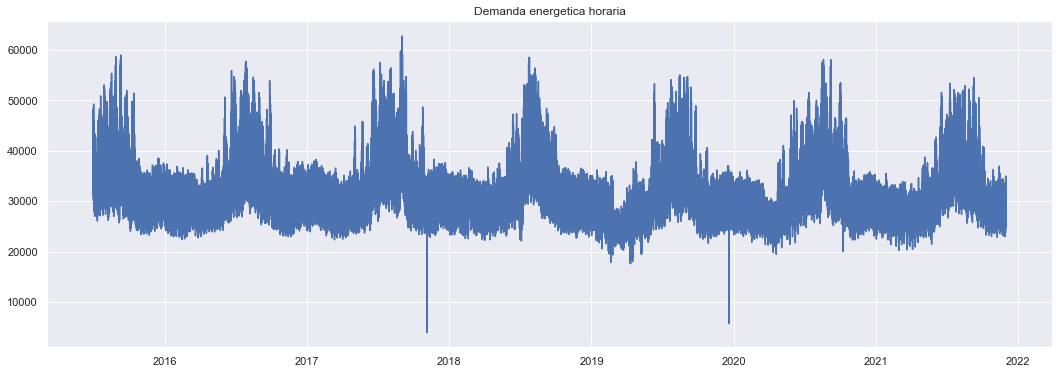

In [53]:
plt.figure(figsize=(18, 6))
plt.title('Demanda energetica horaria')
plt.plot(data)
plt.savefig('images/horario/serietotal.png')
plt.show();

In [54]:
data[data['Demanda'] < 15000]#.index

Demanda
date                        
2017-11-05 01:00:00     3964
2019-12-19 17:00:00     5719
2019-12-19 18:00:00     6103
2019-12-19 19:00:00     6597

In [55]:
data['Demanda'] = np.where(data['Demanda'] < 15000, np.nan, data['Demanda']) 

In [56]:
data[data['Demanda'].isna() == True]

Demanda
date                        
2017-11-05 01:00:00      NaN
2019-12-19 17:00:00      NaN
2019-12-19 18:00:00      NaN
2019-12-19 19:00:00      NaN

In [57]:
data.fillna(method='ffill', inplace=True)

data['Demanda'].isna().sum()

0

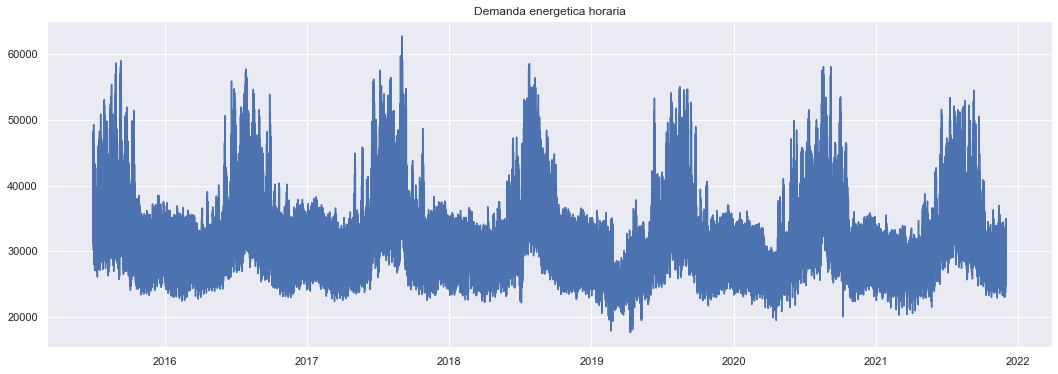

In [64]:
plt.figure(figsize=(18, 6))
plt.title('Demanda energetica horaria')
plt.plot(data)
plt.savefig('images/horario/serietotalsinoutliers.png')
plt.show();

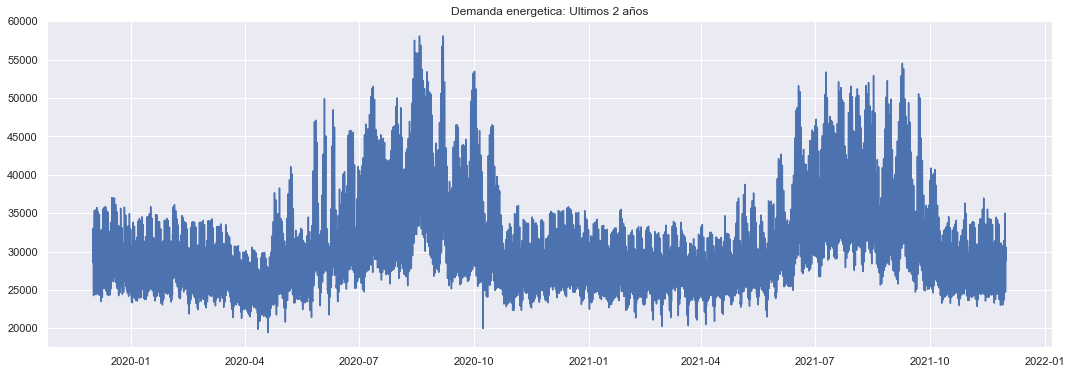

In [65]:
plt.figure(figsize=(18, 6))
plt.title('Demanda energetica: Ultimos 2 años')
plt.plot(data.iloc[-365*24*2:])
plt.savefig('images/horario/serie2anos.png')
plt.show();

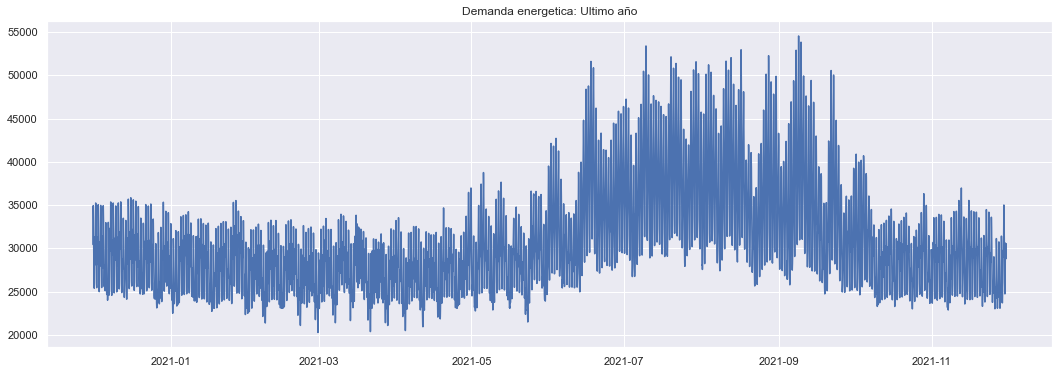

In [66]:
plt.figure(figsize=(18, 6))
plt.title('Demanda energetica: Ultimo año')
plt.plot(data.iloc[-365*24:])
plt.show();

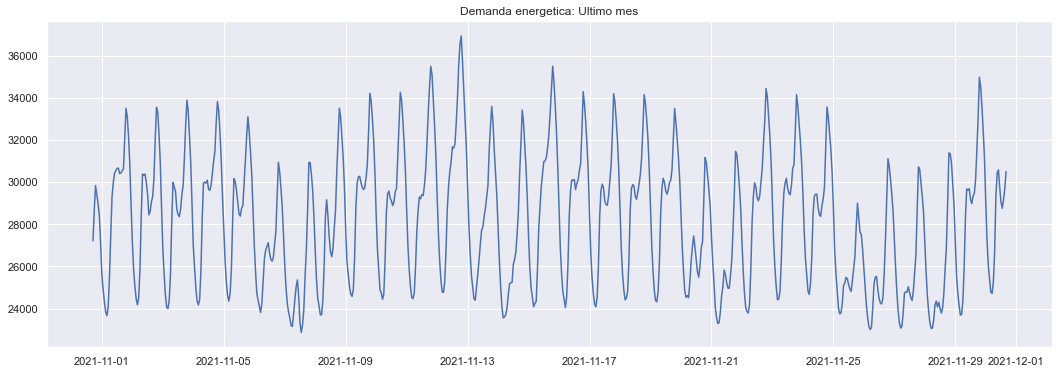

In [67]:
plt.figure(figsize=(18, 6))
plt.title('Demanda energetica: Ultimo mes')
plt.plot(data.iloc[-30*24:])
plt.show();

### Descomposición de la serie

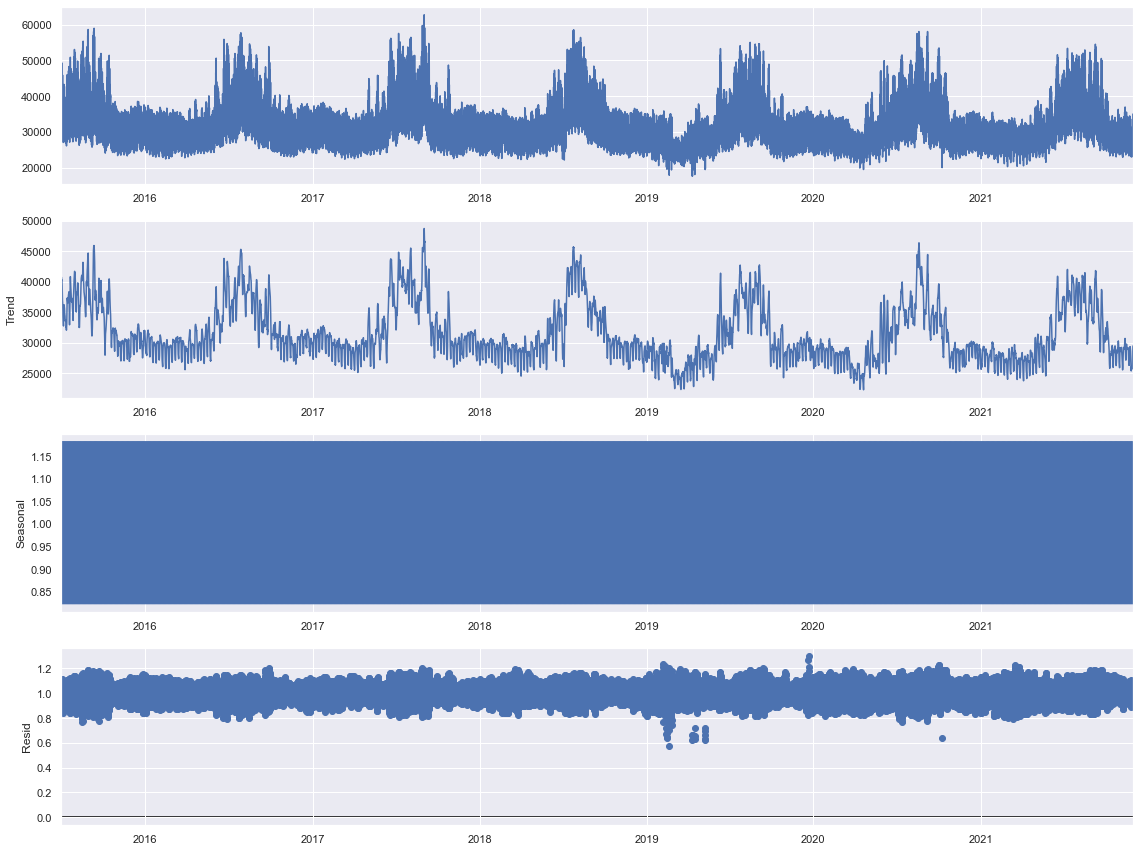

In [68]:
plt.rcParams["figure.figsize"] = (16,12)
result = seasonal_decompose(data, model='multiplicative')
result.plot()
plt.savefig('images/horario/descomp.png')
plt.show();

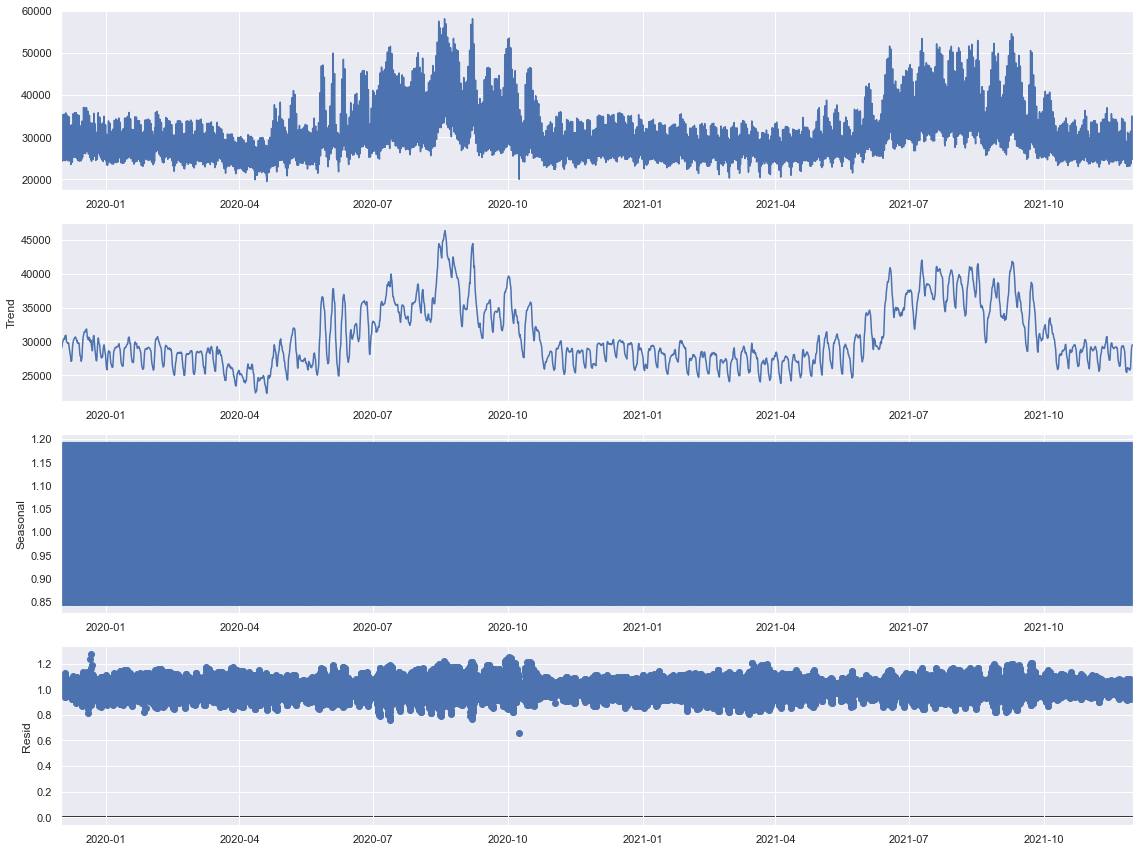

In [69]:
plt.rcParams["figure.figsize"] = (16,12)
result = seasonal_decompose(data.iloc[-365*24*2:], model='multiplicative')
result.plot()
plt.show();

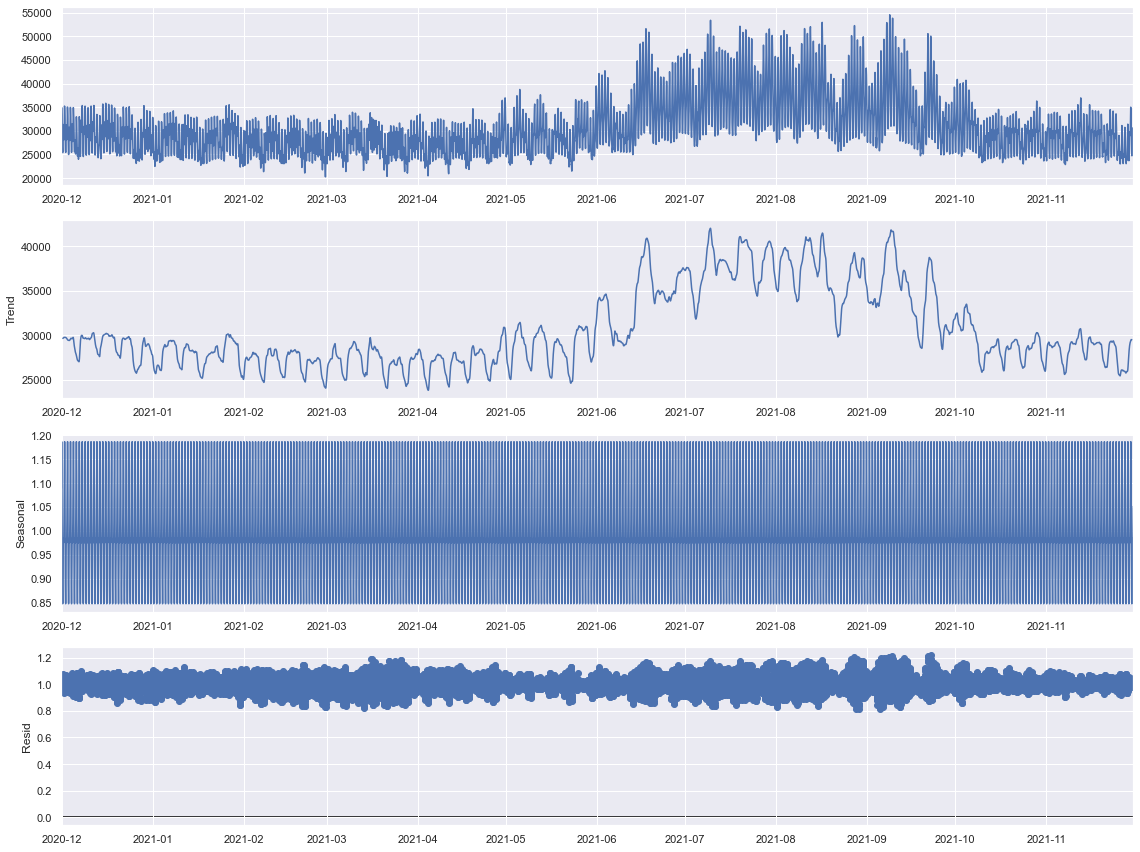

In [70]:
plt.rcParams["figure.figsize"] = (16,12)
result = seasonal_decompose(data.iloc[-365*24:], model='multiplicative')
result.plot()
plt.savefig('images/horario/descompaño.png')
plt.show();

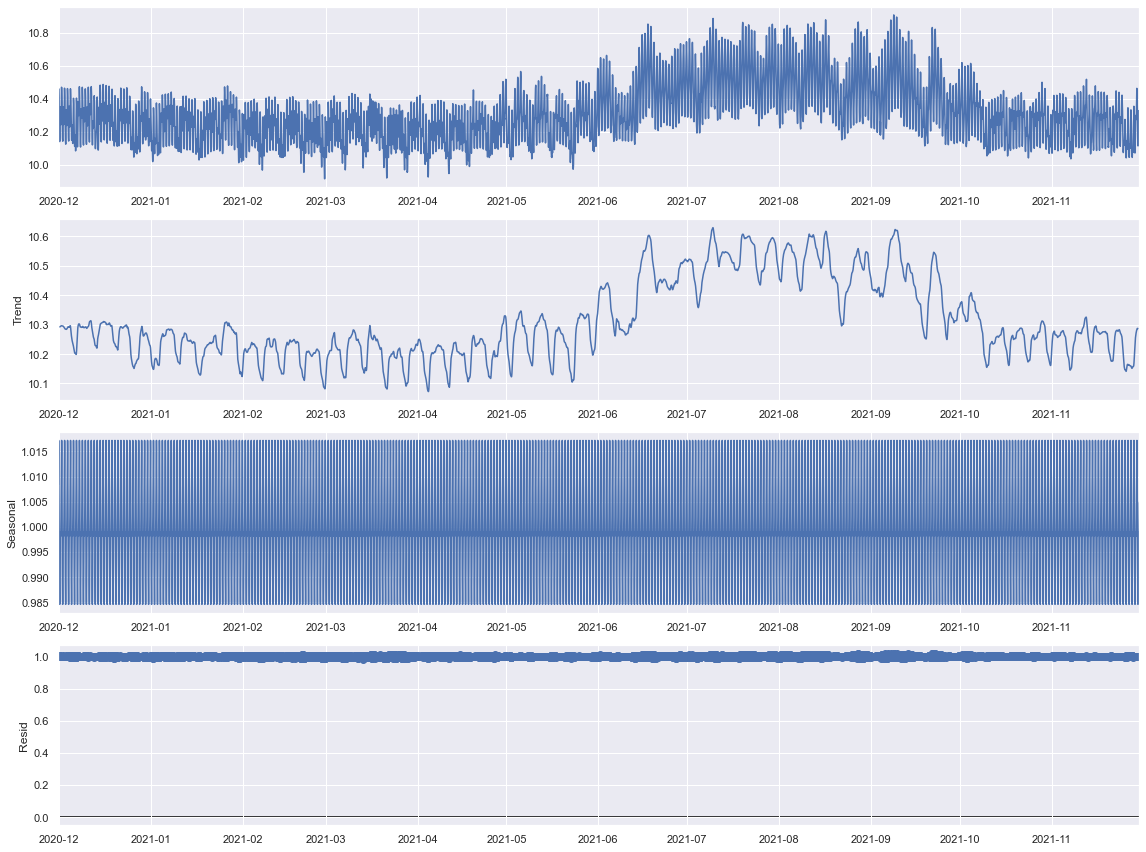

In [71]:
plt.rcParams["figure.figsize"] = (16,12)
result = seasonal_decompose(np.log(data.iloc[-365*24:]), model='multiplicative')
result.plot()
plt.show();

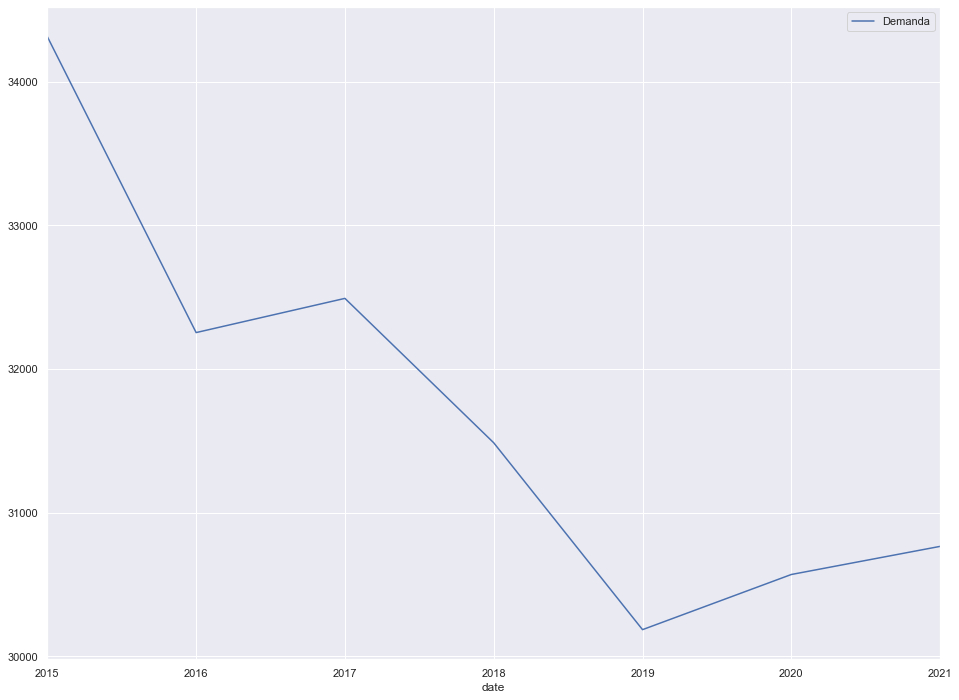

In [72]:
data.resample('Y').mean().plot()
plt.savefig('images/horario/serieanual.png')

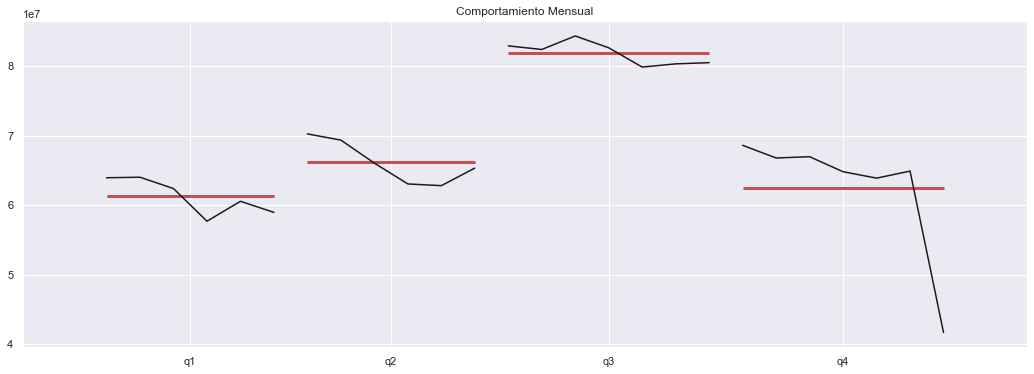

In [73]:
sns.set(rc={'figure.figsize':(18, 6)})
ax = plt.gca()
sm.graphics.tsa.quarter_plot(data.resample('Q').sum(), ax=ax)
ax.set_title('Comportamiento Mensual')
plt.savefig('images/horario/serietrimestral.png')
plt.show()

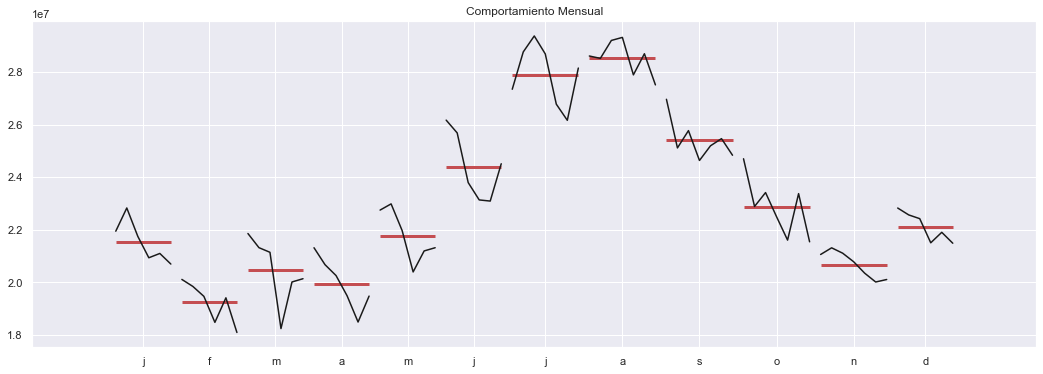

In [74]:
sns.set(rc={'figure.figsize':(18, 6)})
ax = plt.gca()
sm.graphics.tsa.month_plot(data.resample('M').sum(),ax=ax)
ax.set_title('Comportamiento Mensual')
plt.savefig('images/horario/seriemensual.png')
plt.show()

<AxesSubplot:xlabel='week_id'>

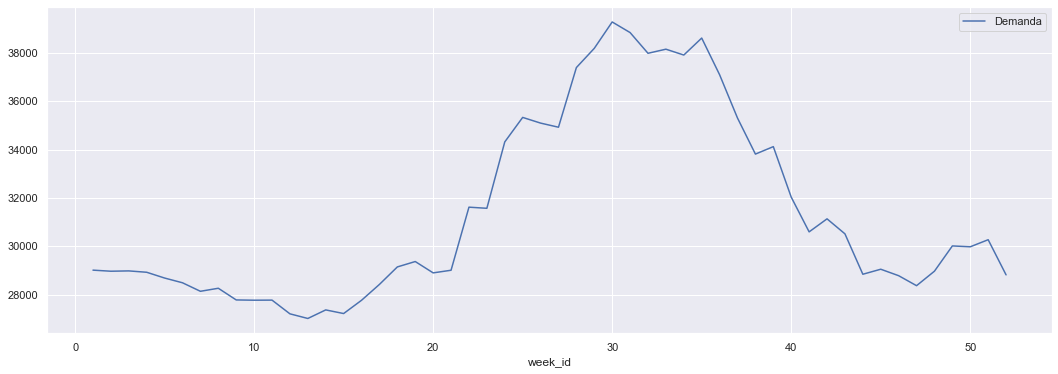

In [75]:
data2 = data.copy()
data2= data2.reset_index()
data2['week_id'] = data2['date'].dt.week
data2[['Demanda', 'week_id']].groupby('week_id').mean().iloc[0:52].plot()

<AxesSubplot:xlabel='week_id'>

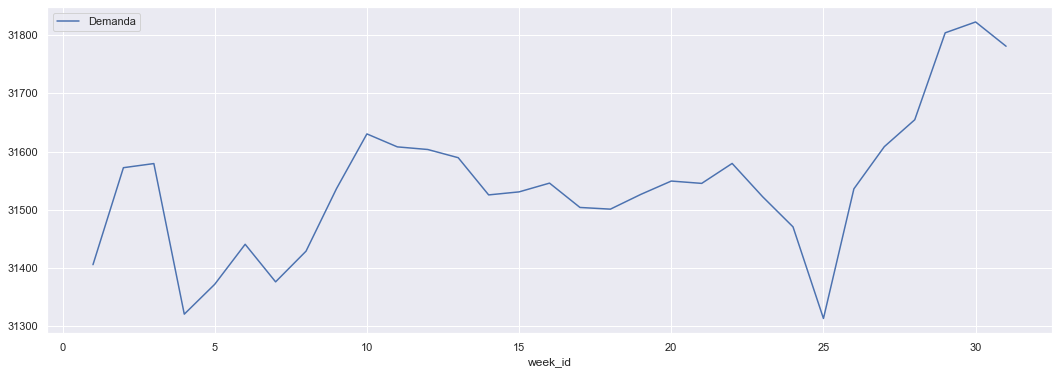

In [76]:
data2 = data.copy()
data2= data2.reset_index()
data2['week_id'] = data2['date'].dt.day
data2[['Demanda', 'week_id']].groupby('week_id').mean().plot()

# Separación test y train

In [58]:
test = data.iloc[-15*24:]
train = data.iloc[:(len(data)-len(test))]

In [59]:
test_log = np.log(data).iloc[-15*24:]
train_log = np.log(data).iloc[:(len(data)-len(test_log))]

# Modelo 0: Media histórica

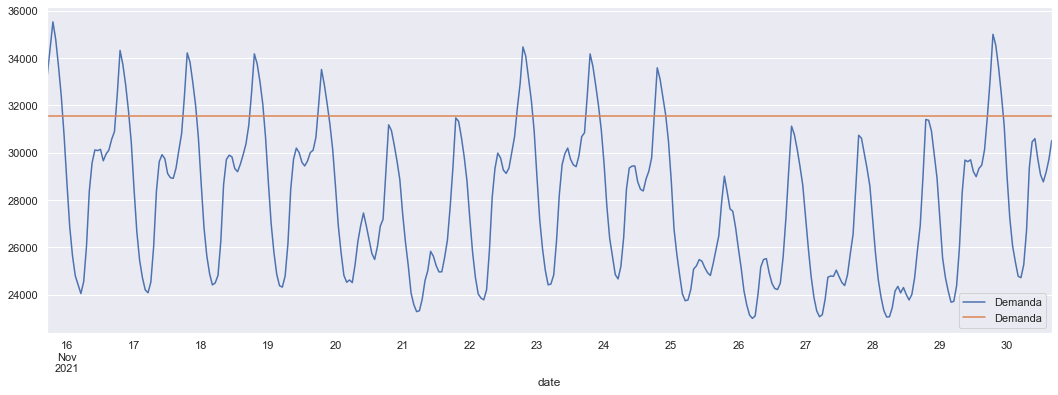

                     Demanda       Demanda
date                                      
2021-11-15 17:00:00  33297.0  31560.035484
2021-11-15 18:00:00  34409.0  31560.035484
2021-11-15 19:00:00  35528.0  31560.035484
2021-11-15 20:00:00  34784.0  31560.035484
2021-11-15 21:00:00  33648.0  31560.035484
...                      ...           ...
2021-11-30 12:00:00  29068.0  31560.035484
2021-11-30 13:00:00  28769.0  31560.035484
2021-11-30 14:00:00  29180.0  31560.035484
2021-11-30 15:00:00  29719.0  31560.035484
2021-11-30 16:00:00  30512.0  31560.035484

[360 rows x 2 columns]

El hecho de intententar predecir a los valores futuros con la media historica genera un MAPE de: 13.95%


In [60]:
media = test.copy()
media['Demanda'] = np.mean(train).iloc[0]

pd.concat([test, media], axis=1).plot()
plt.show();
print(pd.concat([test, media], axis=1))
print('')
print('El hecho de intententar predecir a los valores futuros con la media historica genera un MAPE de: {}%'.format(round((mean_absolute_percentage_error(test, media))*100,2)))

# Modelo 1: AUTOETS

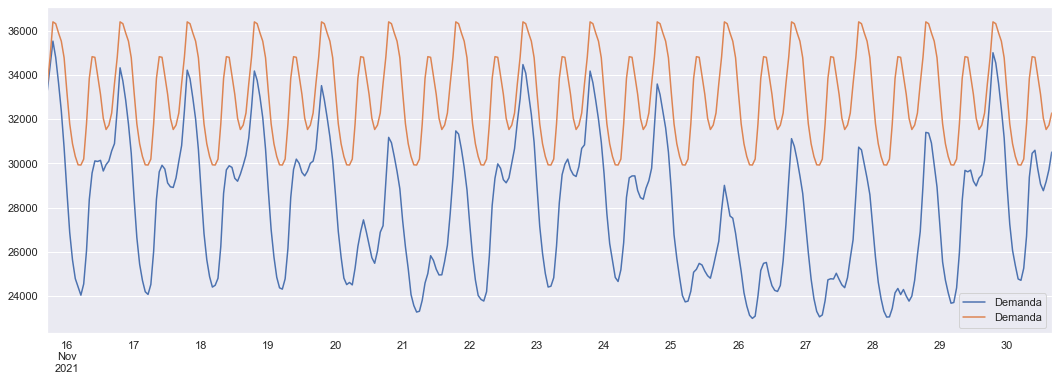

                     Demanda  Demanda
2021-11-15 17:00:00  33297.0    33605
2021-11-15 18:00:00  34409.0    34813
2021-11-15 19:00:00  35528.0    36397
2021-11-15 20:00:00  34784.0    36315
2021-11-15 21:00:00  33648.0    35898
...                      ...      ...
2021-11-30 12:00:00  29068.0    33126
2021-11-30 13:00:00  28769.0    32041
2021-11-30 14:00:00  29180.0    31534
2021-11-30 15:00:00  29719.0    31731
2021-11-30 16:00:00  30512.0    32278

[360 rows x 2 columns]

El modelo ETS genera un MAPE de: 17.15%


In [79]:
ets_model = AutoETS(auto=True, sp=24, n_jobs=-1)
ets_model.fit(train.astype('float64').to_period('H'))
fh = np.arange(1, (len(test)+1))
#fh
ets_pred = ets_model.predict(fh)
ets_pred = ets_pred.astype('int')
ets_pred.index = ets_pred.index.to_timestamp()
pd.concat([test, ets_pred], axis=1).plot()
plt.show();
print(pd.concat([test, ets_pred], axis=1))
print('')
print('El modelo ETS genera un MAPE de: {}%'.format(round((mean_absolute_percentage_error(test, ets_pred))*100,2)))

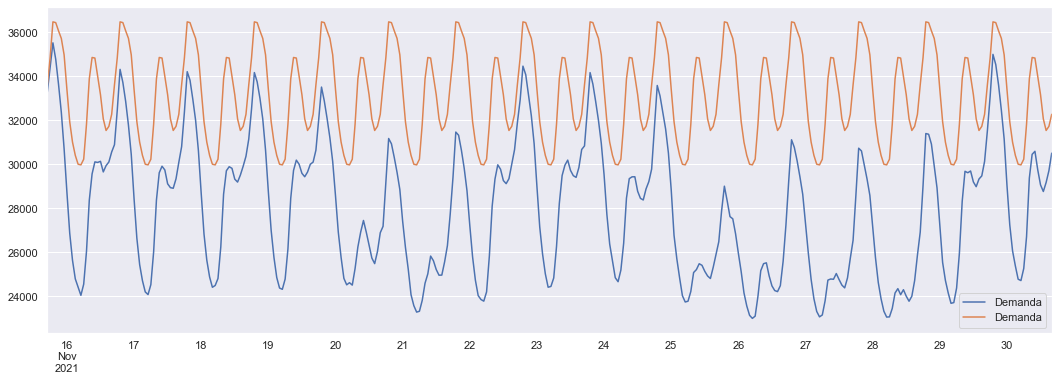

                     Demanda  Demanda
2021-11-15 17:00:00  33297.0    33618
2021-11-15 18:00:00  34409.0    34851
2021-11-15 19:00:00  35528.0    36481
2021-11-15 20:00:00  34784.0    36447
2021-11-15 21:00:00  33648.0    36074
...                      ...      ...
2021-11-30 12:00:00  29068.0    33170
2021-11-30 13:00:00  28769.0    32069
2021-11-30 14:00:00  29180.0    31544
2021-11-30 15:00:00  29719.0    31731
2021-11-30 16:00:00  30512.0    32278

[360 rows x 2 columns]

El modelo ETS en logaritmos genera un MAPE de: 17.37%


In [80]:
ets_model_log = AutoETS(auto=True, sp=24, n_jobs=-1)
ets_model_log.fit(train_log.astype('float64').to_period('H'))
fh = np.arange(1, len(test)+1)
#fh
ets_pred_log = ets_model_log.predict(fh)
ets_pred_log = np.exp(ets_pred_log).astype('int')
ets_pred_log.index = ets_pred_log.index.to_timestamp()
pd.concat([np.exp(test_log), ets_pred_log], axis=1).plot()
plt.show();
print(pd.concat([np.exp(test_log), ets_pred_log], axis=1))
print('')

print('El modelo ETS en logaritmos genera un MAPE de: {}%'.format(round((mean_absolute_percentage_error(np.exp(test_log), ets_pred_log))*100,2)))

# Modelo 2: AUTOARIMA

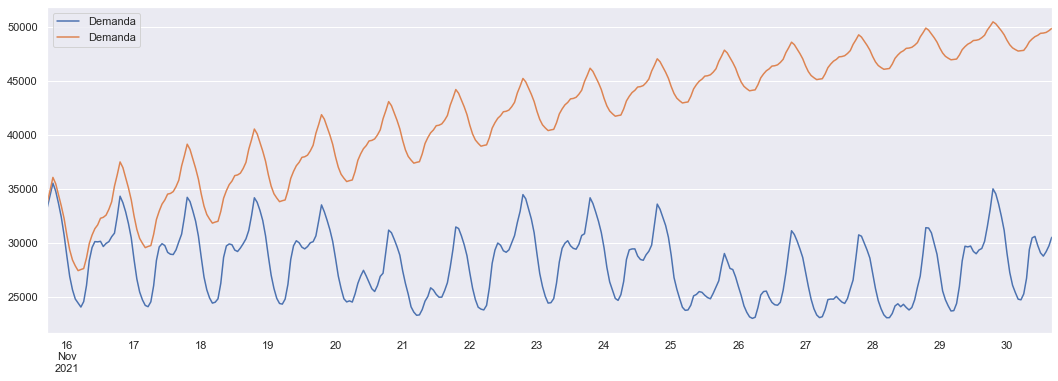

                     Demanda       Demanda
2021-11-15 17:00:00  33297.0  33785.001349
2021-11-15 18:00:00  34409.0  34875.058728
2021-11-15 19:00:00  35528.0  36062.995832
2021-11-15 20:00:00  34784.0  35474.926344
2021-11-15 21:00:00  33648.0  34419.107181
...                      ...           ...
2021-11-30 12:00:00  29068.0  49413.577551
2021-11-30 13:00:00  28769.0  49435.816761
2021-11-30 14:00:00  29180.0  49495.773853
2021-11-30 15:00:00  29719.0  49655.134434
2021-11-30 16:00:00  30512.0  49863.679080

[360 rows x 2 columns]

El modelo ARIMA genera un MAPE de: 39.05%


In [81]:
#  Auto ARIMA Model
forecaster = AutoARIMA(sp=24,suppress_warnings=True)
#  Auto ARIMA Model Estimation
forecaster.fit(train.iloc[-365*24:].to_period('H'))
#  Auto ARIMA Forecast (log)
arima_pred = forecaster.predict(fh)
#  Auto ARIMA Forecast (original)
arima_pred.index = arima_pred.index.to_timestamp()
pd.concat([test, arima_pred], axis=1).plot()
plt.show();
print(pd.concat([test, arima_pred], axis=1))
print('')
print('El modelo ARIMA genera un MAPE de: {}%'.format(round((mean_absolute_percentage_error(test, arima_pred))*100,2)))

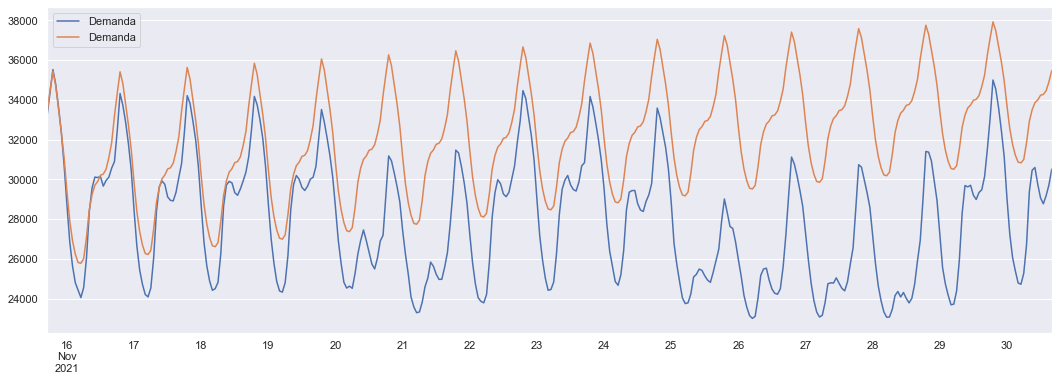

                     Demanda       Demanda
2021-11-15 17:00:00  33297.0  33499.577038
2021-11-15 18:00:00  34409.0  34502.407106
2021-11-15 19:00:00  35528.0  35451.553623
2021-11-15 20:00:00  34784.0  34701.461700
2021-11-15 21:00:00  33648.0  33537.397166
...                      ...           ...
2021-11-30 12:00:00  29068.0  34233.344247
2021-11-30 13:00:00  28769.0  34278.448407
2021-11-30 14:00:00  29180.0  34462.570625
2021-11-30 15:00:00  29719.0  34909.607810
2021-11-30 16:00:00  30512.0  35475.413204

[360 rows x 2 columns]

El modelo ARIMA en logaritmos genera un MAPE de: 14.16%


In [82]:
#  Auto ARIMA Model
forecaster_log = AutoARIMA(sp=24,suppress_warnings=True)
#  Auto ARIMA Model Estimation
forecaster_log.fit(train_log.iloc[-365*24:].to_period('H'))
#  Auto ARIMA Forecast (log)
arima_pred_log = forecaster_log.predict(fh)
#  Auto ARIMA Forecast (original)
arima_pred_log.index = arima_pred_log.index.to_timestamp()
arima_pred_log = np.exp(arima_pred_log)

pd.concat([test, arima_pred_log], axis=1).plot()
plt.show();
print(pd.concat([test, arima_pred_log], axis=1))
print('')
print('El modelo ARIMA en logaritmos genera un MAPE de: {}%'.format(round((mean_absolute_percentage_error(test, arima_pred_log))*100,2)))

# Modelo 3: PROPHET

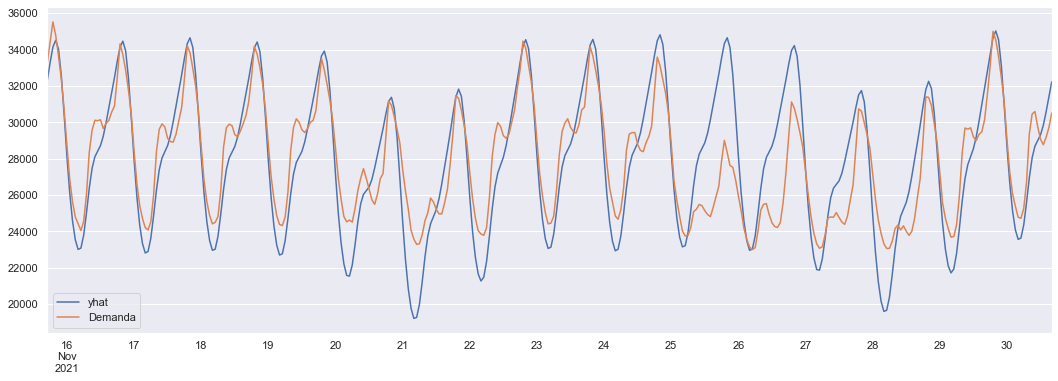


                      yhat  Demanda
2021-11-15 17:00:00  32316  33297.0
2021-11-15 18:00:00  33287  34409.0
2021-11-15 19:00:00  34144  35528.0
2021-11-15 20:00:00  34516  34784.0
2021-11-15 21:00:00  34026  33648.0
...                    ...      ...
2021-11-30 12:00:00  29313  29068.0
2021-11-30 13:00:00  29839  28769.0
2021-11-30 14:00:00  30584  29180.0
2021-11-30 15:00:00  31410  29719.0
2021-11-30 16:00:00  32231  30512.0

[360 rows x 2 columns]

El modelo Prophet genera un MAPE de: 5.9%


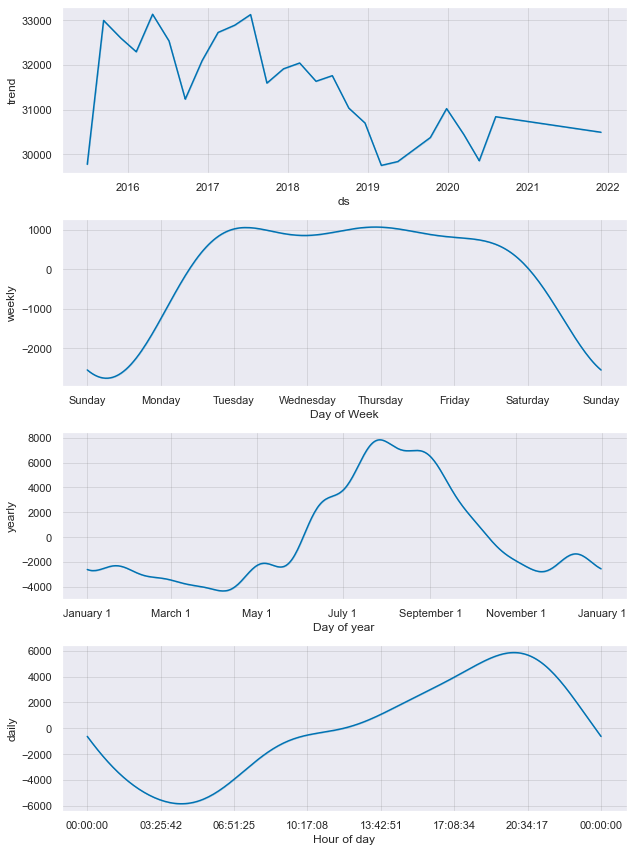

In [83]:
prophet_train = train.reset_index()
prophet_train.columns = ['ds', 'y']


m = Prophet()
m.fit(prophet_train)
periods = len(test)
future = m.make_future_dataframe(periods=periods, freq='H')
forecast = m.predict(future)
prophet_pred = forecast[['ds','yhat']].copy()
prophet_pred.set_index(['ds'], inplace=True)
pd.concat([prophet_pred.iloc[-periods:].astype('int'), test], axis=1).plot()
plt.show();
print('')
print(pd.concat([prophet_pred.iloc[-periods:].astype('int'), test], axis=1))
print('')

print('El modelo Prophet genera un MAPE de: {}%'.format(round((mean_absolute_percentage_error(test, prophet_pred.iloc[-periods:].astype('int')))*100,2)))

fig2 = m.plot_components(forecast)
plt.show();

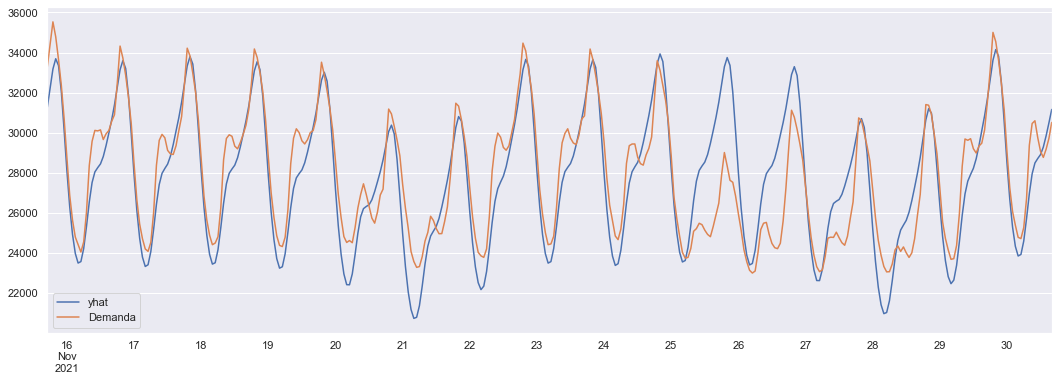


                      yhat  Demanda
2021-11-15 17:00:00  31273  33297.0
2021-11-15 18:00:00  32234  34409.0
2021-11-15 19:00:00  33174  35528.0
2021-11-15 20:00:00  33689  34784.0
2021-11-15 21:00:00  33349  33648.0
...                    ...      ...
2021-11-30 12:00:00  28909  29068.0
2021-11-30 13:00:00  29286  28769.0
2021-11-30 14:00:00  29849  29180.0
2021-11-30 15:00:00  30491  29719.0
2021-11-30 16:00:00  31160  30512.0

[360 rows x 2 columns]

El modelo Prophet con logaritmos genera un MAPE de: 4.67%


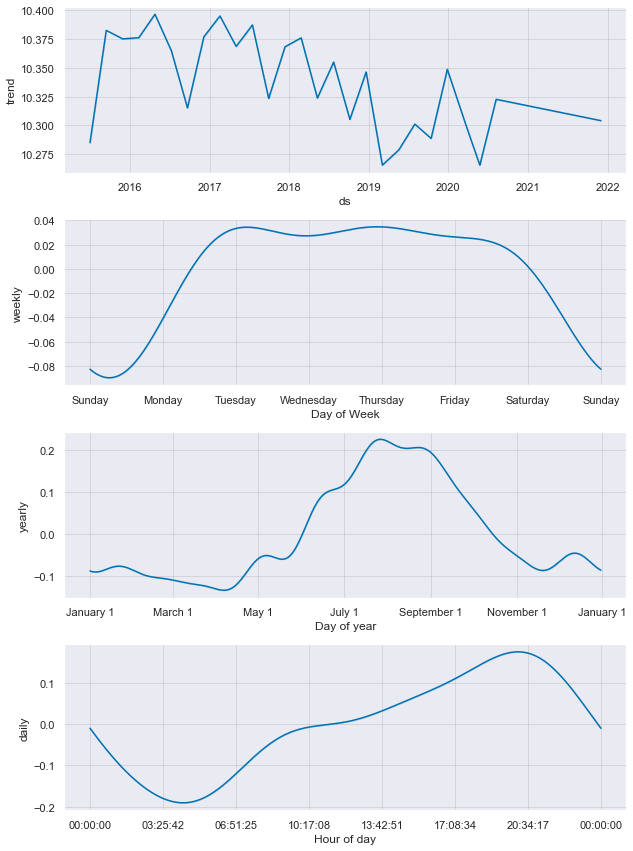

In [84]:
prophet_train_log = train_log.reset_index()
prophet_train_log.columns = ['ds', 'y']

m_log = Prophet()
m_log.fit(prophet_train_log)
periods = len(test)
future_log = m_log.make_future_dataframe(periods=periods, freq='H')
forecast_log = m_log.predict(future_log)
prophet_pred_log = forecast_log[['ds','yhat']].copy()
prophet_pred_log.set_index(['ds'], inplace=True)
prophet_pred_log = np.exp(prophet_pred_log)
pd.concat([prophet_pred_log.iloc[-periods:].astype('int'), test], axis=1).plot()
plt.savefig('images/horario/prednov.png')
plt.show();
print('')
print(pd.concat([prophet_pred_log.iloc[-periods:].astype('int'), test], axis=1))
print('')

print('El modelo Prophet con logaritmos genera un MAPE de: {}%'.format(round((mean_absolute_percentage_error(test, prophet_pred_log.iloc[-periods:].astype('int')))*100,2)))

fig2 = m_log.plot_components(forecast_log)
plt.savefig('images/horario/componentprednov.png')
plt.show();

In [85]:
data.tail()

Demanda
date                        
2021-11-30 12:00:00  29068.0
2021-11-30 13:00:00  28769.0
2021-11-30 14:00:00  29180.0
2021-11-30 15:00:00  29719.0
2021-11-30 16:00:00  30512.0

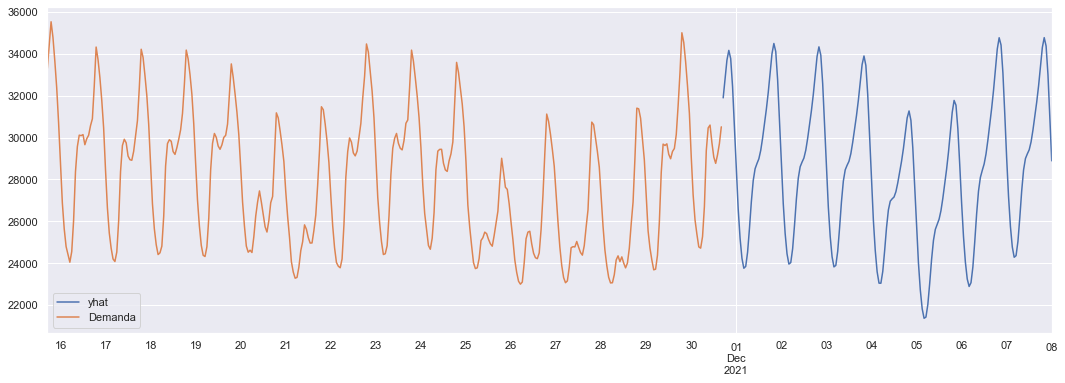


                     Demanda
2021-11-30 01:00:00  27257.0
2021-11-30 02:00:00  26071.0
2021-11-30 03:00:00  25388.0
2021-11-30 04:00:00  24781.0
2021-11-30 05:00:00  24720.0
...                      ...
2021-12-07 20:00:00  34770.0
2021-12-07 21:00:00  34370.0
2021-12-07 22:00:00  32999.0
2021-12-07 23:00:00  30998.0
2021-12-08 00:00:00  28889.0

[192 rows x 1 columns]



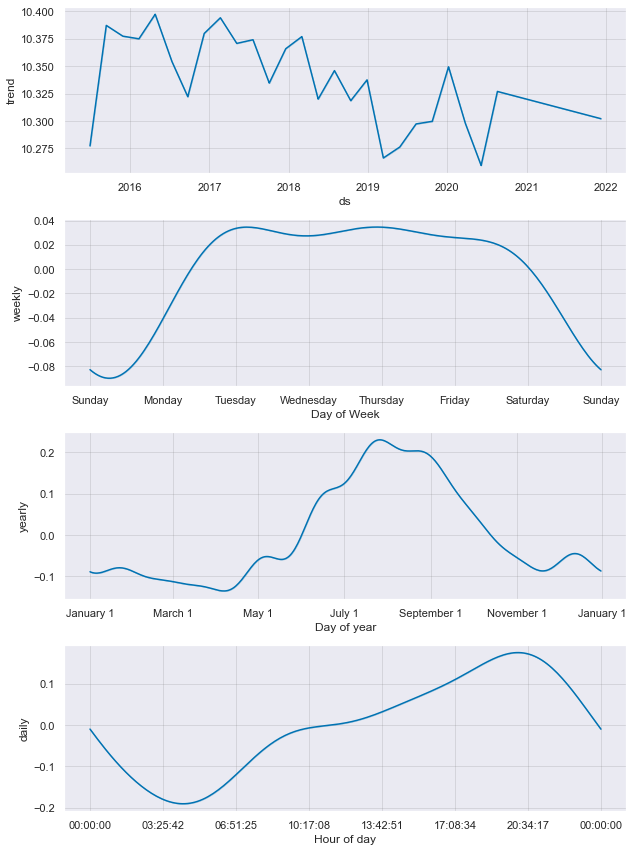

In [86]:
prophet_train_log = np.log(data).reset_index()
prophet_train_log.columns = ['ds', 'y']

m_log = Prophet()
m_log.fit(prophet_train_log)
periods = (7*24)+8
future_log = m_log.make_future_dataframe(periods=periods, freq='H')
forecast_log = m_log.predict(future_log)
prophet_pred_log = forecast_log[['ds','yhat']].copy()
prophet_pred_log.set_index(['ds'], inplace=True)
prophet_pred_log = np.exp(prophet_pred_log)
pd.concat([prophet_pred_log.iloc[-periods:].astype('int'), test], axis=1).plot()
plt.savefig('images/horario/predfinal.png')
plt.show();
print('')
pred = prophet_pred_log.rename_axis(index=None).rename(columns={'yhat': 'Demanda'}).iloc[-periods:].astype('int')
data2 = data.append(pred)
print(data2.tail(8*24))
print('')

fig2 = m_log.plot_components(forecast_log)
plt.savefig('images/horario/componentpredfinal.png')
plt.show();

In [87]:
pred.iloc[7:168+7].reset_index().rename(columns={'index':'date'}).to_csv('hourly_prediction.csv', encoding='utf-8')

In [88]:
pd.set_option('display.max_rows', 180)
pred.iloc[7:168+7]

Demanda
2021-12-01 00:00:00    28388
2021-12-01 01:00:00    26584
2021-12-01 02:00:00    25190
2021-12-01 03:00:00    24235
2021-12-01 04:00:00    23761
2021-12-01 05:00:00    23849
2021-12-01 06:00:00    24528
2021-12-01 07:00:00    25666
2021-12-01 08:00:00    26933
2021-12-01 09:00:00    27945
2021-12-01 10:00:00    28512
2021-12-01 11:00:00    28761
2021-12-01 12:00:00    28985
2021-12-01 13:00:00    29389
2021-12-01 14:00:00    29980
2021-12-01 15:00:00    30652
2021-12-01 16:00:00    31354
2021-12-01 17:00:00    32150
2021-12-01 18:00:00    33088
2021-12-01 19:00:00    34007
2021-12-01 20:00:00    34491
2021-12-01 21:00:00    34106
2021-12-01 22:00:00    32752
2021-12-01 23:00:00    30769
2021-12-02 00:00:00    28673
2021-12-02 01:00:00    26844
2021-12-02 02:00:00    25428
2021-12-02 03:00:00    24452
2021-12-02 04:00:00    23960
2021-12-02 05:00:00    24031
2021-12-02 06:00:00    24697
2021-12-02 07:00:00    25822
2021-12-02 08:00:00    27072
2021-12-02 09:00:00    28062
2021-12-02 10:00:00    28604
2021-12-02 11:00:00    28827
2021-12-02 12:00:00    29023
2021-12-02 13:00:00    29399
2021-12-02 14:00:00    29963
2021-12-02 15:00:00    30608
2021-12-02 16:00:00    31284
2021-12-02 17:00:00    32055
2021-12-02 18:00:00    32969
2021-12-02 19:00:00    33865
2021-12-02 20:00:00    34330
2021-12-02 21:00:00    33934
2021-12-02 22:00:00    32577
2021-12-02 23:00:00    30597
2021-12-03 00:00:00    28510
2021-12-03 01:00:00    26689
2021-12-03 02:00:00    25281
2021-12-03 03:00:00    24312
2021-12-03 04:00:00    23825
2021-12-03 05:00:00    23899
2021-12-03 06:00:00    24565
2021-12-03 07:00:00    25686
2021-12-03 08:00:00    26933
2021-12-03 09:00:00    27919
2021-12-03 10:00:00    28458
2021-12-03 11:00:00    28677
2021-12-03 12:00:00    28866
2021-12-03 13:00:00    29231
2021-12-03 14:00:00    29778
2021-12-03 15:00:00    30400
2021-12-03 16:00:00    31047
2021-12-03 17:00:00    31780
2021-12-03 18:00:00    32648
2021-12-03 19:00:00    33488
2021-12-03 20:00:00    33894
2021-12-03 21:00:00    33442
2021-12-03 22:00:00    32039
2021-12-03 23:00:00    30024
2021-12-04 00:00:00    27907
2021-12-04 01:00:00    26056
2021-12-04 02:00:00    24611
2021-12-04 03:00:00    23596
2021-12-04 04:00:00    23050
2021-12-04 05:00:00    23046
2021-12-04 06:00:00    23607
2021-12-04 07:00:00    24598
2021-12-04 08:00:00    25700
2021-12-04 09:00:00    26547
2021-12-04 10:00:00    26963
2021-12-04 11:00:00    27075
2021-12-04 12:00:00    27161
2021-12-04 13:00:00    27414
2021-12-04 14:00:00    27840
2021-12-04 15:00:00    28338
2021-12-04 16:00:00    28864
2021-12-04 17:00:00    29474
2021-12-04 18:00:00    30215
2021-12-04 19:00:00    30938
2021-12-04 20:00:00    31270
2021-12-04 21:00:00    30822
2021-12-04 22:00:00    29512
2021-12-04 23:00:00    27653
2021-12-05 00:00:00    25712
2021-12-05 01:00:00    24027
2021-12-05 02:00:00    22725
2021-12-05 03:00:00    21828
2021-12-05 04:00:00    21373
2021-12-05 05:00:00    21430
2021-12-05 06:00:00    22025
2021-12-05 07:00:00    23038
2021-12-05 08:00:00    24174
2021-12-05 09:00:00    25089
2021-12-05 10:00:00    25616
2021-12-05 11:00:00    25866
2021-12-05 12:00:00    26102
2021-12-05 13:00:00    26511
2021-12-05 14:00:00    27100
2021-12-05 15:00:00    27774
2021-12-05 16:00:00    28487
2021-12-05 17:00:00    29299
2021-12-05 18:00:00    30254
2021-12-05 19:00:00    31206
2021-12-05 20:00:00    31772
2021-12-05 21:00:00    31545
2021-12-05 22:00:00    30423
2021-12-05 23:00:00    28707
2021-12-06 00:00:00    26875
2021-12-06 01:00:00    25279
2021-12-06 02:00:00    24060
2021-12-06 03:00:00    23249
2021-12-06 04:00:00    22891
2021-12-06 05:00:00    23071
2021-12-06 06:00:00    23824
2021-12-06 07:00:00    25026
2021-12-06 08:00:00    26358
2021-12-06 09:00:00    27445
2021-12-06 10:00:00    28097
2021-12-06 11:00:00    28432
2021-12-06 12:00:00    28738
2021-12-06 13:00:00    29219
2021-12-06 14:00:00    29883
2021-12-06 15:00:00    30624
2021-12-06 16:00:00    31393
2021-12-06 17:00:00